In [1]:
import sqlite3
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

from bgfunc import *

loading data/LIWC/LIWC2007_English100131_words.dic
loading LIWC with stopVal=0.5, for 906 words
loading data/LIWC/LIWC2007_English100131_words.dic
loading LIWC with stopVal=0.0, for 4483 words
loading LabMT with stopVal=1.0, for 3731 words
loading ANEW with stopVal=1.0, for 765 words


/Users/andrew/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Load SQLite database 

In [2]:
dbfile = 'project_june10_705pm.db'
conn = sqlite3.connect(dbfile)

## Analysis parameters 

Which condition are we studying?  Are there any cutoffs based on testing?

In [3]:
platform = 'ig' # ig = instagram, tw = twitter
condition = 'depression' # depression, pregnancy, ptsd, cancer

In [4]:
specs = analysis_specifications(platform, condition)

platform_long = specs['plong'][platform]
gb_types = specs['gb_types'][platform]
fields = specs['fields'][platform] 
test_name = specs['test_name'][condition]
test_cutoff = specs['test_cutoff'][condition]
photos_rated = specs['photos_rated'][condition]
has_test = specs['has_test'][condition]

clfs = ['lr','rf'] # lr = logistic regression, rf = random forests, svc = support vector
periods = ['before','after']
turn_points = ['from_diag','from_susp']

impose_test_cutoff = True # do we want to limit target pop based on testing cutoff (eg. cesd > 21)?

limit_date_range = True # do we want to restrict posts by date range? 

posting_cutoff = True # Drops usernames with fewer than (mean - 0.5std) total posts (for mcmc p-val improvement)

additional_data = True # for instagram, do we also get photo ratings? (This is proxy for limit_date_range in places)

report_sample_size = False # simple reporting feature

load_from_pickle = False # loads entire data dict, including masters, from pickle file
write_to_pickle = False # writes initial data (prepare_raw_data()) to pickle file

final_pickle = True # pickles entire data dict after all masters are created

populate_wordfeats_db = False # generates word features from reagan code (twitter only)

compare_ig_filters = False # Instagram only, compares use of filters between target and control pops


run_master = True 
run_subsets = True
run_separate_pca = True

action_params = {
    'create_master': True, 
    'save_to_file' : True, 
    'density' : True, 
    'ml' : False, 
    'nhst' : True, 
    'corr' : False, 
    'print_corrmat' : False,
    'tall_plot': True
}

params = define_params(condition, test_name, test_cutoff, impose_test_cutoff,
                       platform, platform_long, fields, photos_rated, has_test, additional_data)

In [5]:
# printout showing sample sizes for target and control groups
if report_sample_size:
    report_sample_sizes(params, conn, condition, platform_long, test_cutoff, test_name)

## Load ready data, or prepare raw data

Set load_from_pickle to determine action here.  

In case you don't have a pickled data dict, or if you want to make a new one, the next block will:

- Pulls data from db
- Aggregates in buckets (day, week, user)
- Creates before/after diag/susp date subsets along with whole

Otherwise we load existing cleaned/aggregated data from pickle

In [6]:
if load_from_pickle:
    data = pickle.load( open( "{cond}_{pl}_data.p".format(cond=condition,pl=platform), "rb" ) )
    
else:
    data = make_data_dict(params, condition, test_name, conn)
    prepare_raw_data(data, platform, params, conn, gb_types, condition, periods, turn_points, posting_cutoff,
                    additional_data=additional_data, limit_date_range=limit_date_range)
    if write_to_pickle:
        pickle.dump( data, open( "{cond}_{pl}_data.p".format(cond=condition,pl=platform), "wb" ) )
    

TARGET DATA:
Number photos with HSV ratings (all conditions): 71962
Num HSV-rated photos with URL in TARGET, before dropping duplicates: 6357
Num HSV-rated photos with URL in TARGET, after dropping duplicates: 6357
Shape of consolidated TARGET RATINGS data: (22691, 19)
Shape of consolidated TARGET ALL data: (22691, 22)
target pop before cut: (51, 21)
target pop after cut: (34, 21)

('Subset shape for IG BEFORE FROM_DIAG:', (10883, 22))
('Subset shape for IG BEFORE FROM_SUSP:', (2119, 22))
('Subset shape for IG AFTER FROM_DIAG:', (8698, 22))
('Subset shape for IG AFTER FROM_SUSP:', (3710, 22))

CONTROL DATA:
Number photos with HSV ratings (all conditions): 71962
Num HSV-rated photos with URL in CONTROL, before dropping duplicates: 19595
Num HSV-rated photos with URL in CONTROL, after dropping duplicates: 19139
Shape of consolidated CONTROL RATINGS data: (21986, 19)
Shape of consolidated CONTROL ALL data: (21983, 22)
target pop before cut: (82, 21)
target pop after cut: (61, 21)



In [7]:
if compare_ig_filters:
    compare_filters(data, conn)

## Construct master dataset & run analyses

Possible actions:
- generate master data
- save to disk
- plot target vs control densities for each variable
- correlation plot
- ML modeling
- NHST


Merge to master: MAIN post
master post shape: (11206, 16)

target vs control for IG POST-groupby:


/Users/andrew/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


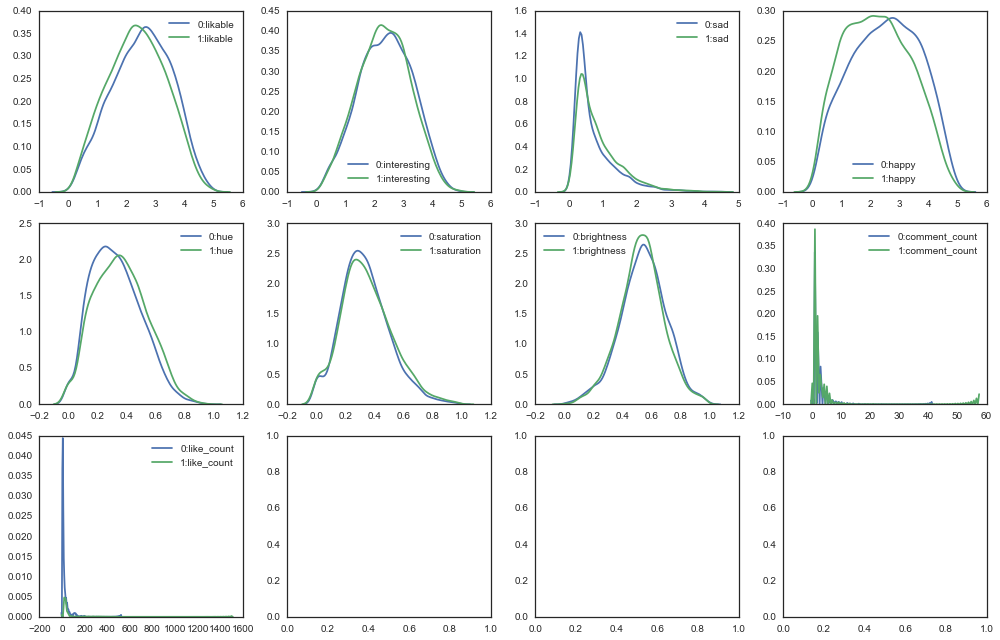


TTEST
UNIT OF MEASUREMENT: post

RATING: likable
Ttest_indResult(statistic=8.5931849690137838, pvalue=9.5798188087899331e-18)

RATING: interesting
Ttest_indResult(statistic=3.5706200055796025, pvalue=0.00035762893071418343)

RATING: sad
Ttest_indResult(statistic=-9.6045509131594127, pvalue=9.2778048487359659e-22)

RATING: happy
Ttest_indResult(statistic=12.705714064049193, pvalue=9.8513017037907108e-37)

RATING: hue
Ttest_indResult(statistic=-10.315266053780713, pvalue=7.8004112053309153e-25)

RATING: saturation
Ttest_indResult(statistic=-4.332919374650432, pvalue=1.4845154012044965e-05)

RATING: brightness
Ttest_indResult(statistic=4.4909930557258351, pvalue=7.1614043694938175e-06)

RATING: comment_count
Ttest_indResult(statistic=1.290581218775511, pvalue=0.19692961497527092)

RATING: like_count
Ttest_indResult(statistic=1.169212431574876, pvalue=0.24239398694076966)

bonferroni-corrected alpha of 0.05: 0.00555555555556
likable significant post-correction? True (8.62183692791e-17)
in

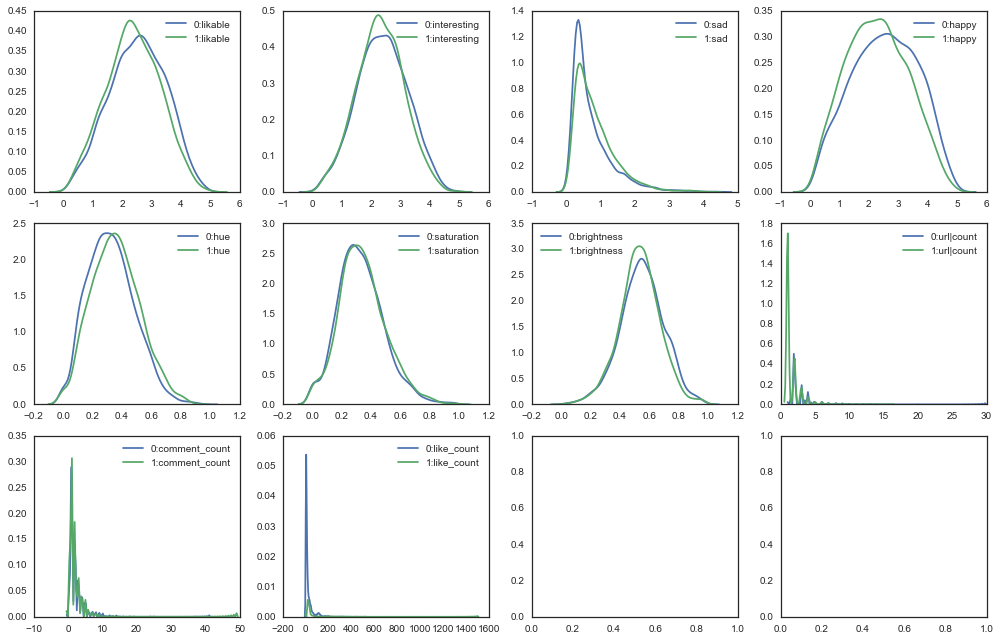


TTEST
UNIT OF MEASUREMENT: created_date

RATING: likable
Ttest_indResult(statistic=6.9151603124327989, pvalue=5.0582470228704543e-12)

RATING: interesting
Ttest_indResult(statistic=3.6966758272084359, pvalue=0.00022000080051426366)

RATING: sad
Ttest_indResult(statistic=-7.2686125658214848, pvalue=3.9989103078126952e-13)

RATING: happy
Ttest_indResult(statistic=10.026131571900963, pvalue=1.6456251491567212e-23)

RATING: hue
Ttest_indResult(statistic=-8.6724320211050241, pvalue=5.1408937566243344e-18)

RATING: saturation
Ttest_indResult(statistic=-3.1524395326224708, pvalue=0.0016255980441592236)

RATING: brightness
Ttest_indResult(statistic=5.3565166657071304, pvalue=8.739763154741697e-08)

RATING: url|count
Ttest_indResult(statistic=-5.4478820074452337, pvalue=5.2614291655144628e-08)

RATING: comment_count
Ttest_indResult(statistic=4.0253904577565827, pvalue=5.8237949948842006e-05)

RATING: like_count
Ttest_indResult(statistic=2.192168919443596, pvalue=0.028441395174422943)

bonferro

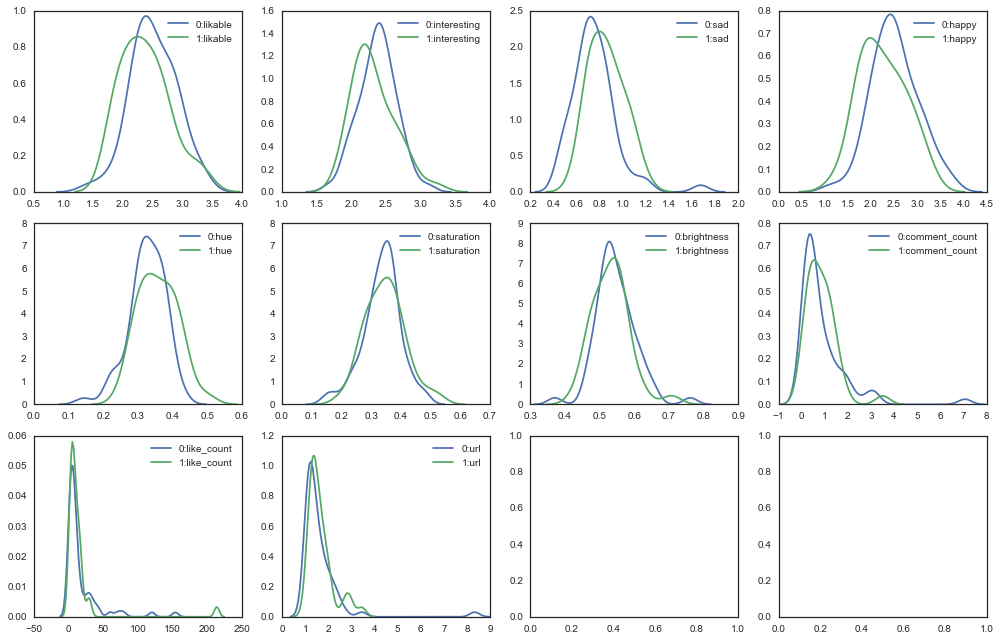


TTEST
UNIT OF MEASUREMENT: username

RATING: likable
Ttest_indResult(statistic=1.6705185611336464, pvalue=0.098179114185393906)

RATING: interesting
Ttest_indResult(statistic=0.90334984987804623, pvalue=0.36867418896732207)

RATING: sad
Ttest_indResult(statistic=-2.5722347727706456, pvalue=0.011688225422394593)

RATING: happy
Ttest_indResult(statistic=2.4427917708355453, pvalue=0.016462807943096906)

RATING: hue
Ttest_indResult(statistic=-2.7723022632968823, pvalue=0.0067240930957385347)

RATING: saturation
Ttest_indResult(statistic=-0.77987978877723252, pvalue=0.43744192590807573)

RATING: brightness
Ttest_indResult(statistic=1.2044479521964067, pvalue=0.2314728180831635)

RATING: comment_count
Ttest_indResult(statistic=0.19354111446916908, pvalue=0.84695729451103963)

RATING: like_count
Ttest_indResult(statistic=0.31275332942174877, pvalue=0.75516832114586308)

RATING: url
Ttest_indResult(statistic=-0.26504826093578698, pvalue=0.79155886721002355)

bonferroni-corrected alpha of 0.05

In [8]:
if run_master:
    master = data['master']
    target = data['target']['gb']
    control = data['control']['gb'] 
    report = 'MAIN'
    
    if action_params['create_master']:
        master['model'] = {}

    for gb_type in gb_types:

        master_actions(master, target, control, condition, platform, 
                       params, gb_type, report, action_params, clfs, additional_data, posting_cutoff)

## Subset master actions

Same as above block, but for subsets, eg. target before diag_date vs controls

Reporting for: SUBSETS
Period: BEFORE  Focus: FROM_DIAG  Groupby: POST

Merge to master: before_from_diag post
master post shape: (10453, 16)

target vs control for IG POST-groupby:


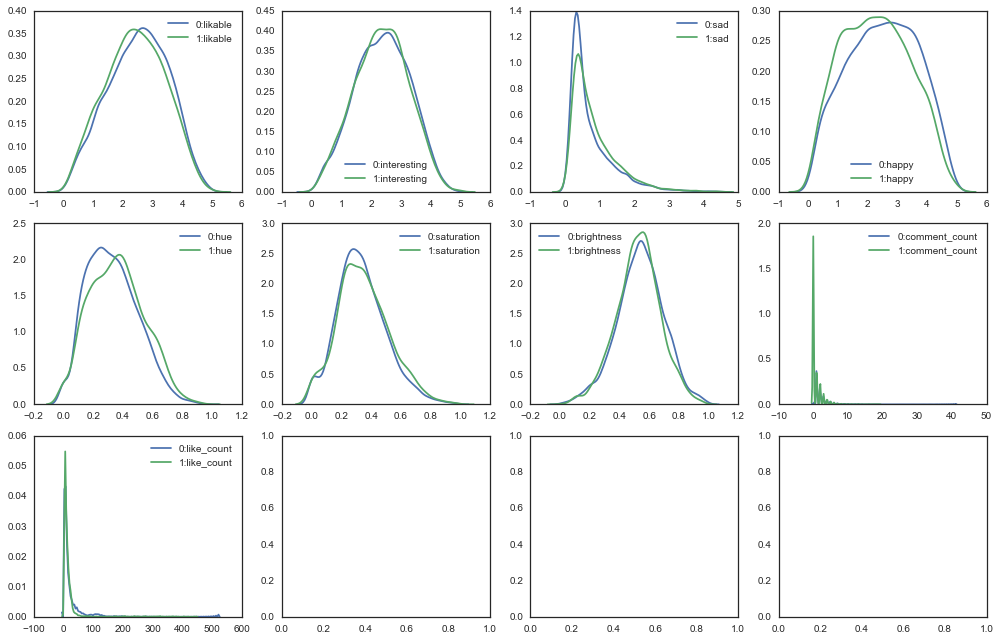

Correlation matrix:


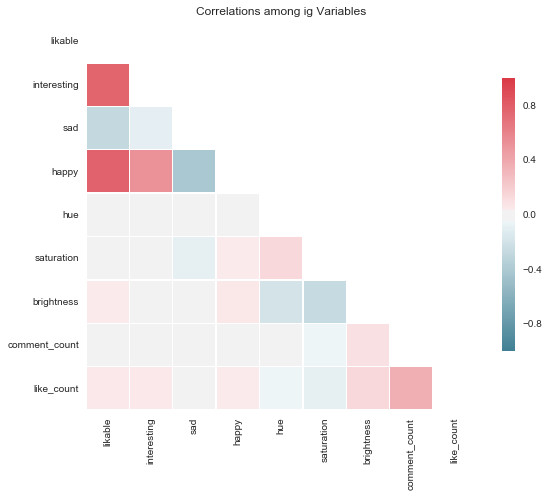

Building ML models...

UNIT OF OBSERVATION: POST
NAIVE ACCURACY ALL NULL: 0.676
  *'ALL NULL' means if all observations are predicted as uncompleted assessments


MODEL: Logistic Regression target (Models: before_from_diag post):
NAIVE ACCURACY: 0.583

CONFUSION MATRIX (lr):
               pred_control  pred_target
known_control          1248          873
known_target            436          579

Proportion of pred_target in known_control: 0.412
Proportion of pred_target in known_target: 0.57




/Users/andrew/anaconda/lib/python2.7/site-packages/sklearn/utils/class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


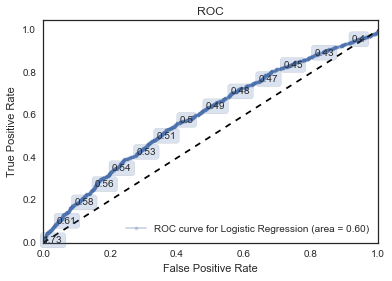

MODEL: Random Forests target (Models: before_from_diag post):
NAIVE ACCURACY: 0.683

CONFUSION MATRIX (rf):
               pred_control  pred_target
known_control          1990          131
known_target            864          151

Proportion of pred_target in known_control: 0.062
Proportion of pred_target in known_target: 0.149




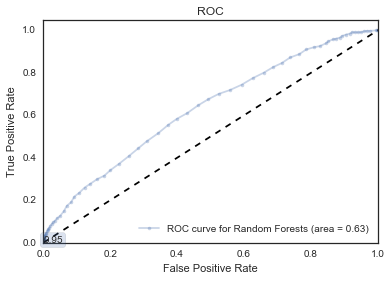

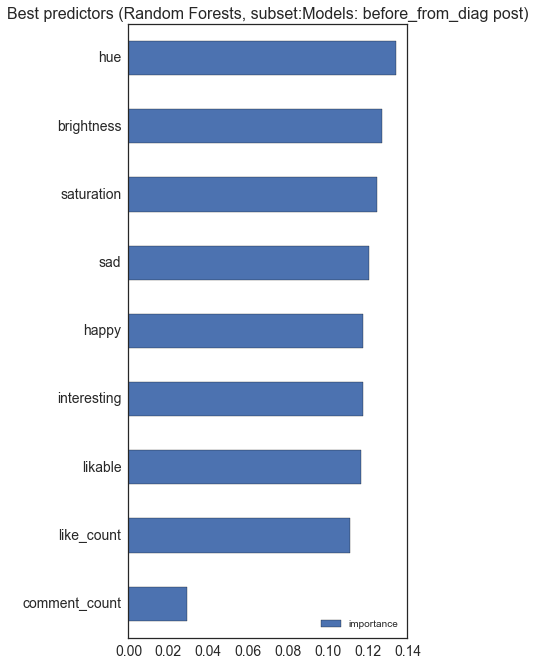


TTEST
UNIT OF MEASUREMENT: post

RATING: likable
Ttest_indResult(statistic=4.8943714055734606, pvalue=1.0009429576200577e-06)

RATING: interesting
Ttest_indResult(statistic=1.3893196472242808, pvalue=0.164765173648806)

RATING: sad
Ttest_indResult(statistic=-6.7165648962645443, pvalue=1.9573962583346098e-11)

RATING: happy
Ttest_indResult(statistic=9.1173619368480612, pvalue=9.1104397624775497e-20)

RATING: hue
Ttest_indResult(statistic=-9.5759540069032667, pvalue=1.2429101818296581e-21)

RATING: saturation
Ttest_indResult(statistic=-4.6529847326655878, pvalue=3.3126398102901757e-06)

RATING: brightness
Ttest_indResult(statistic=4.7226637908059281, pvalue=2.3586447518902464e-06)

RATING: comment_count
Ttest_indResult(statistic=2.6100769887495661, pvalue=0.0090918856448191261)

RATING: like_count
Ttest_indResult(statistic=0.43465133124713073, pvalue=0.66384340877745829)

bonferroni-corrected alpha of 0.05: 0.00555555555556
likable significant post-correction? True (9.00848661858e-06)
i

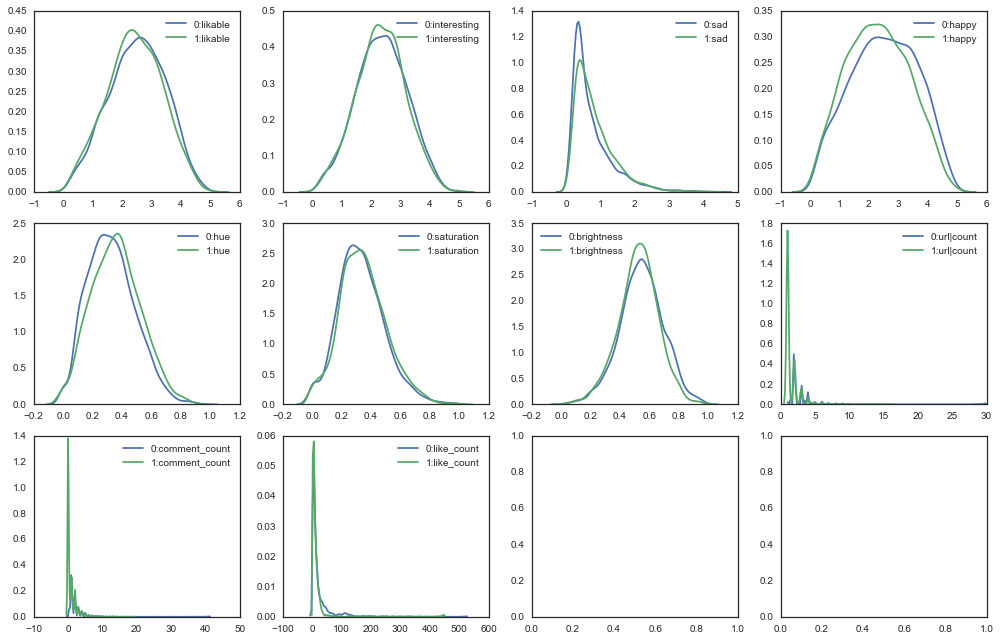

Correlation matrix:


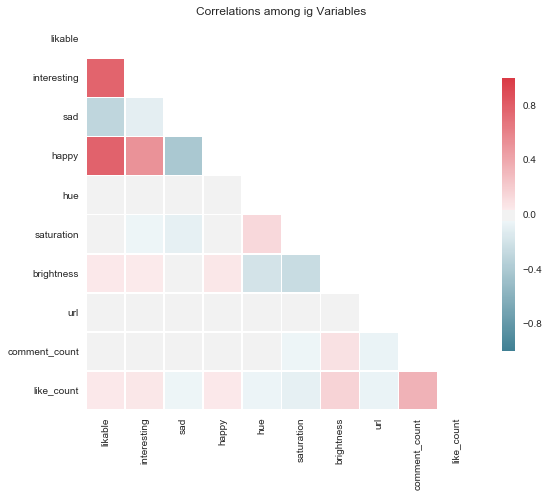

Building ML models...

UNIT OF OBSERVATION: CREATED_DATE
NAIVE ACCURACY ALL NULL: 0.695
  *'ALL NULL' means if all observations are predicted as uncompleted assessments


MODEL: Logistic Regression target (Models: before_from_diag created_date):
NAIVE ACCURACY: 0.578

CONFUSION MATRIX (lr):
               pred_control  pred_target
known_control           874          631
known_target            282          379

Proportion of pred_target in known_control: 0.419
Proportion of pred_target in known_target: 0.573




/Users/andrew/anaconda/lib/python2.7/site-packages/sklearn/utils/class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


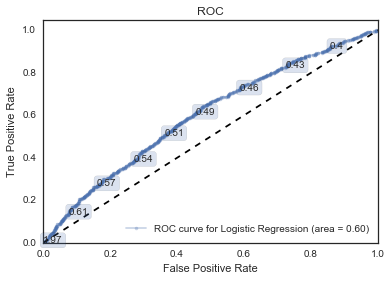

MODEL: Random Forests target (Models: before_from_diag created_date):
NAIVE ACCURACY: 0.697

CONFUSION MATRIX (rf):
               pred_control  pred_target
known_control          1416           89
known_target            567           94

Proportion of pred_target in known_control: 0.059
Proportion of pred_target in known_target: 0.142




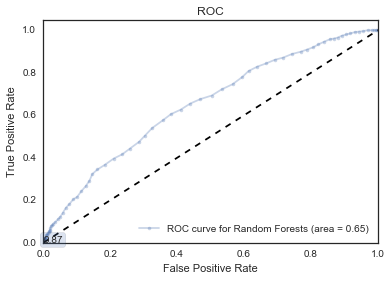

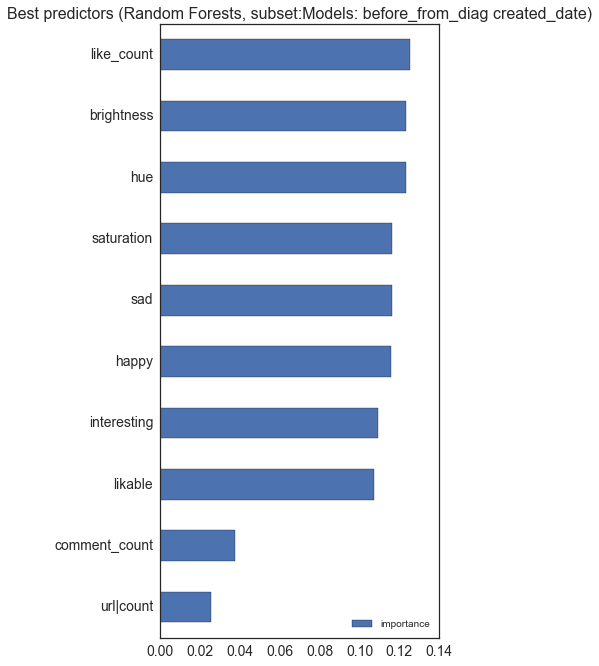


TTEST
UNIT OF MEASUREMENT: created_date

RATING: likable
Ttest_indResult(statistic=3.6908077372302346, pvalue=0.00022519017988840975)

RATING: interesting
Ttest_indResult(statistic=1.4457876722537397, pvalue=0.1482801870703431)

RATING: sad
Ttest_indResult(statistic=-4.9408203117014837, pvalue=7.9546383094803689e-07)

RATING: happy
Ttest_indResult(statistic=7.3700134281218528, pvalue=1.8958530936594955e-13)

RATING: hue
Ttest_indResult(statistic=-8.2966270184323605, pvalue=1.2698522742580636e-16)

RATING: saturation
Ttest_indResult(statistic=-3.4914223893863849, pvalue=0.00048337223041388738)

RATING: brightness
Ttest_indResult(statistic=6.0803826854890666, pvalue=1.2609761520292779e-09)

RATING: url|count
Ttest_indResult(statistic=-4.1530942801814117, pvalue=3.3184484676139785e-05)

RATING: comment_count
Ttest_indResult(statistic=4.1610393922360736, pvalue=3.2591457144256199e-05)

RATING: like_count
Ttest_indResult(statistic=1.2345306318982103, pvalue=0.21710481578991808)

bonferroni

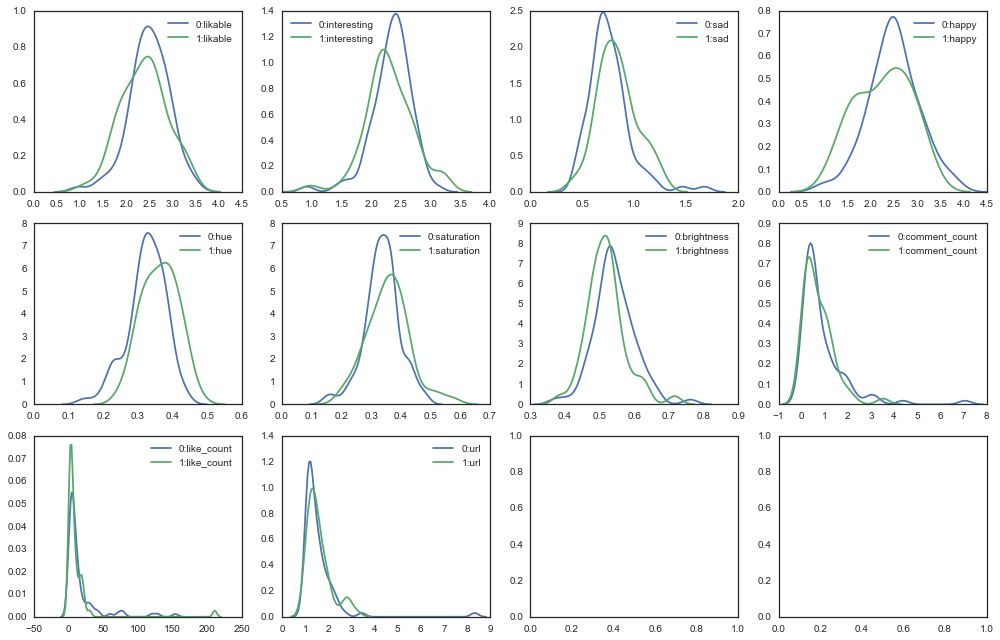

Correlation matrix:


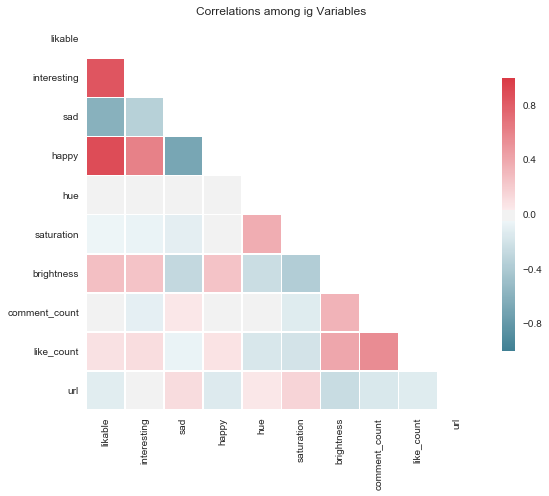

Building ML models...

UNIT OF OBSERVATION: USERNAME
NAIVE ACCURACY ALL NULL: 0.575
  *'ALL NULL' means if all observations are predicted as uncompleted assessments


MODEL: Logistic Regression target (Models: before_from_diag username):
NAIVE ACCURACY: 0.575

CONFUSION MATRIX (lr):
               pred_control  pred_target
known_control            10           13
known_target              4           13

Proportion of pred_target in known_control: 0.565
Proportion of pred_target in known_target: 0.765




/Users/andrew/anaconda/lib/python2.7/site-packages/sklearn/utils/class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


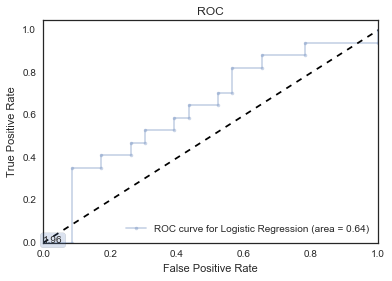

MODEL: Random Forests target (Models: before_from_diag username):
NAIVE ACCURACY: 0.675

CONFUSION MATRIX (rf):
               pred_control  pred_target
known_control            18            5
known_target              8            9

Proportion of pred_target in known_control: 0.217
Proportion of pred_target in known_target: 0.529




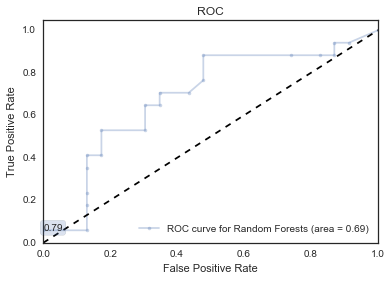

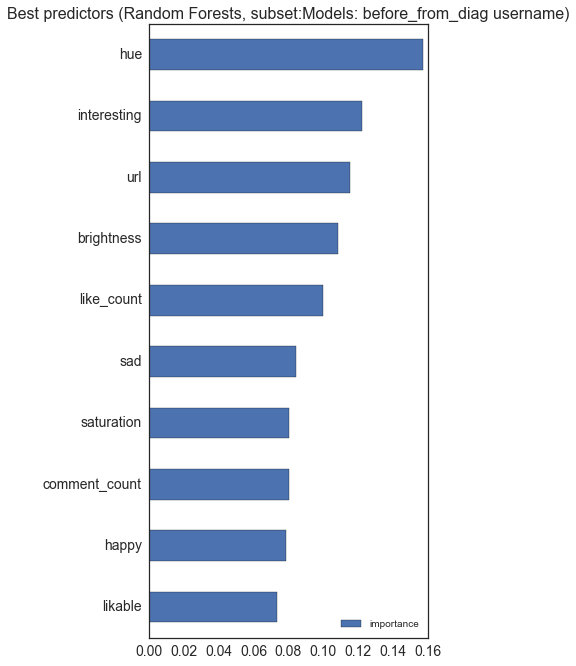


TTEST
UNIT OF MEASUREMENT: username

RATING: likable
Ttest_indResult(statistic=1.3494195066470709, pvalue=0.17952977774763945)

RATING: interesting
Ttest_indResult(statistic=0.67574260366650674, pvalue=0.50039523549911769)

RATING: sad
Ttest_indResult(statistic=-2.0611899152511146, pvalue=0.041263016182442637)

RATING: happy
Ttest_indResult(statistic=2.2541747307067839, pvalue=0.025845863691393568)

RATING: hue
Ttest_indResult(statistic=-3.9800535176602048, pvalue=0.00011351512365022138)

RATING: saturation
Ttest_indResult(statistic=-1.7596023148401272, pvalue=0.080809641880513108)

RATING: brightness
Ttest_indResult(statistic=2.3399915084179477, pvalue=0.020795459943973131)

RATING: comment_count
Ttest_indResult(statistic=0.89005457103693941, pvalue=0.37509348004789556)

RATING: like_count
Ttest_indResult(statistic=1.0866882953440937, pvalue=0.27920095297921566)

RATING: url
Ttest_indResult(statistic=-0.14845098852350905, pvalue=0.88221866809838678)

bonferroni-corrected alpha of 0.0

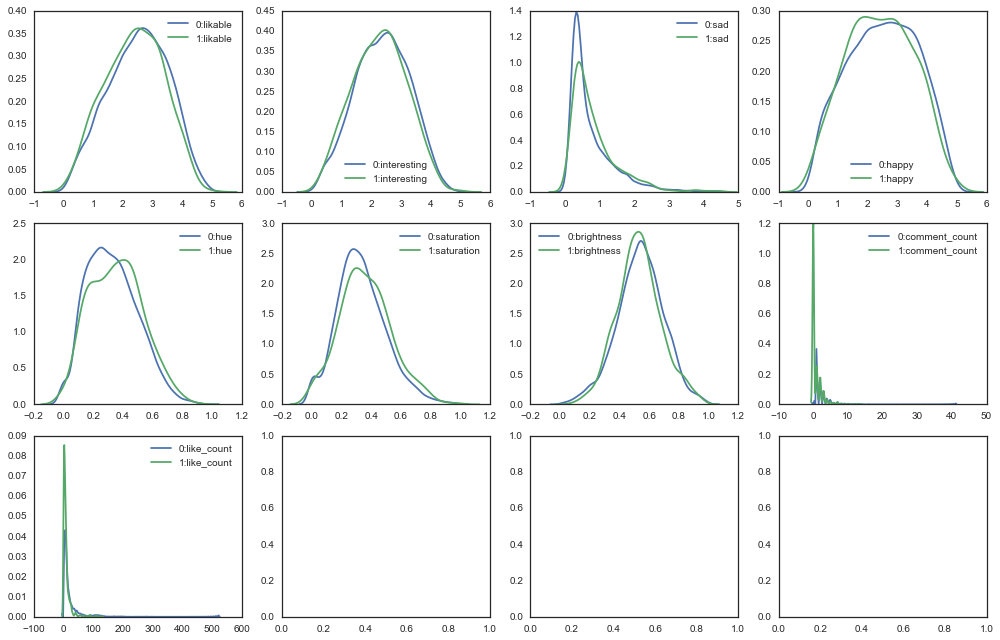

Correlation matrix:


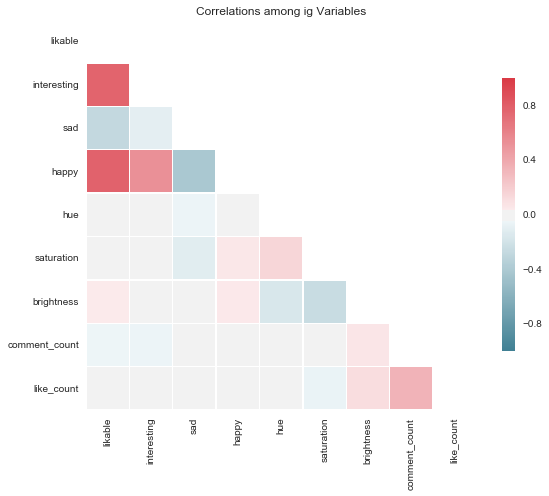

Building ML models...

UNIT OF OBSERVATION: POST
NAIVE ACCURACY ALL NULL: 0.912
  *'ALL NULL' means if all observations are predicted as uncompleted assessments


MODEL: Logistic Regression target (Models: before_from_susp post):
NAIVE ACCURACY: 0.538

CONFUSION MATRIX (lr):
               pred_control  pred_target
known_control          1125         1001
known_target             77          129

Proportion of pred_target in known_control: 0.471
Proportion of pred_target in known_target: 0.626




/Users/andrew/anaconda/lib/python2.7/site-packages/sklearn/utils/class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


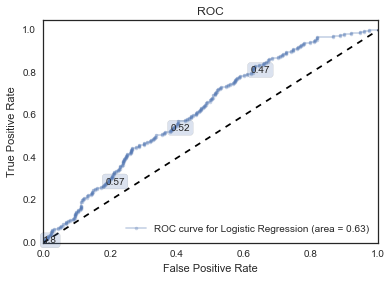

MODEL: Random Forests target (Models: before_from_susp post):
NAIVE ACCURACY: 0.911

CONFUSION MATRIX (rf):
               pred_control  pred_target
known_control          2125            1
known_target            206            0

Proportion of pred_target in known_control: 0.0
Proportion of pred_target in known_target: 0.0




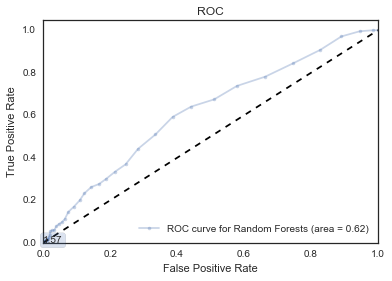

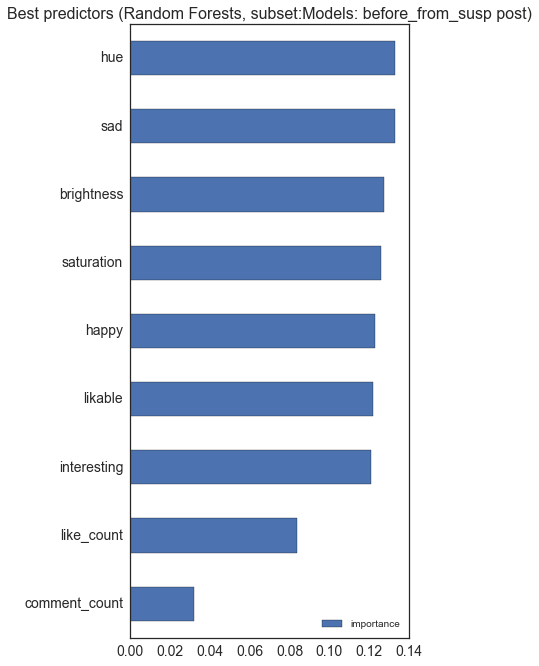


TTEST
UNIT OF MEASUREMENT: post

RATING: likable
Ttest_indResult(statistic=3.3313835419513391, pvalue=0.00086818723122256255)

RATING: interesting
Ttest_indResult(statistic=2.4972980644963707, pvalue=0.012534905531141083)

RATING: sad
Ttest_indResult(statistic=-3.4657118552074406, pvalue=0.00053169174771483529)

RATING: happy
Ttest_indResult(statistic=1.9784248175823311, pvalue=0.0479161093450498)

RATING: hue
Ttest_indResult(statistic=-4.0011691099628912, pvalue=6.3626046196568981e-05)

RATING: saturation
Ttest_indResult(statistic=-3.8557437657365918, pvalue=0.00011632600787381382)

RATING: brightness
Ttest_indResult(statistic=1.5307948649839438, pvalue=0.12586153398852915)

RATING: comment_count
Ttest_indResult(statistic=1.2628333959670501, pvalue=0.20676594330029388)

RATING: like_count
Ttest_indResult(statistic=5.6050827981732745, pvalue=2.3106658598092492e-08)

bonferroni-corrected alpha of 0.05: 0.00555555555556
likable significant post-correction? True (0.007813685081)
interest

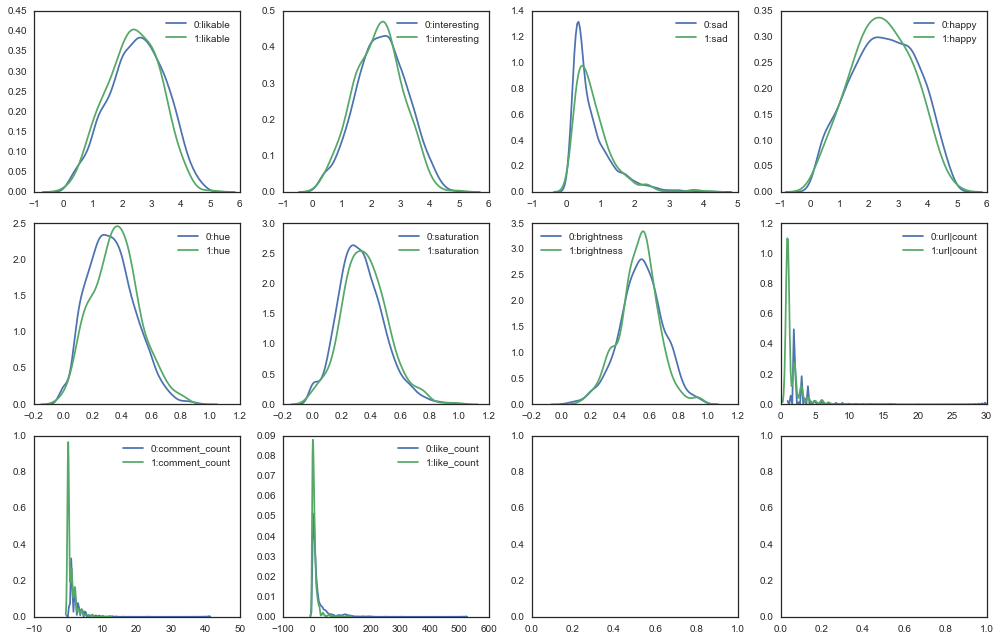

Correlation matrix:


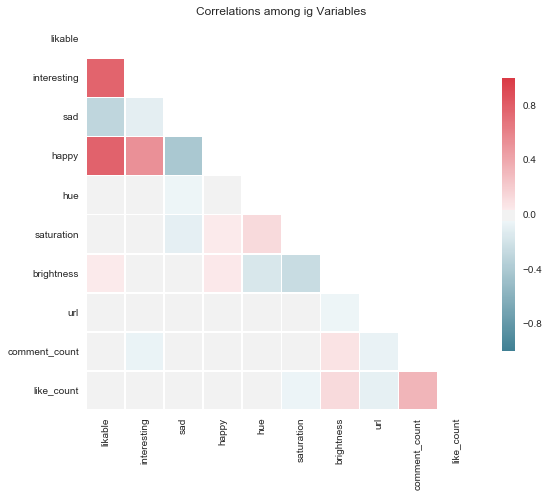

Building ML models...

UNIT OF OBSERVATION: CREATED_DATE
NAIVE ACCURACY ALL NULL: 0.927
  *'ALL NULL' means if all observations are predicted as uncompleted assessments


MODEL: Logistic Regression target (Models: before_from_susp created_date):
NAIVE ACCURACY: 0.539

CONFUSION MATRIX (lr):
               pred_control  pred_target
known_control           802          711
known_target             42           78

Proportion of pred_target in known_control: 0.47
Proportion of pred_target in known_target: 0.65




/Users/andrew/anaconda/lib/python2.7/site-packages/sklearn/utils/class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


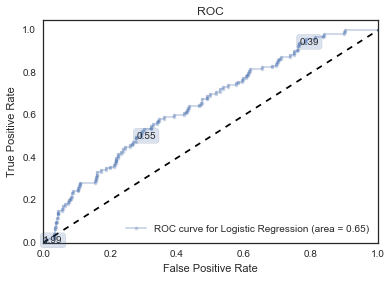

MODEL: Random Forests target (Models: before_from_susp created_date):
NAIVE ACCURACY: 0.927

CONFUSION MATRIX (rf):
               pred_control  pred_target
known_control          1513            0
known_target            120            0

Proportion of pred_target in known_control: 0.0
Proportion of pred_target in known_target: 0.0




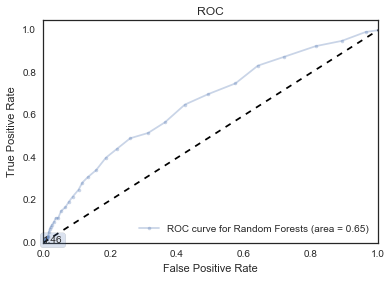

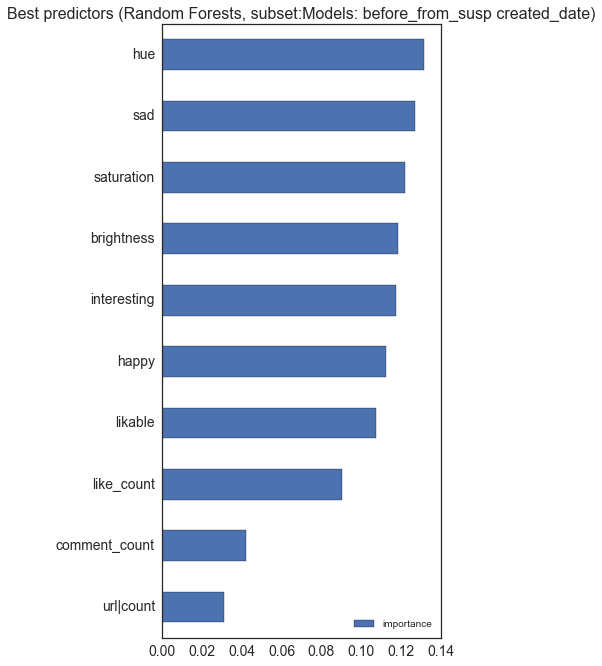


TTEST
UNIT OF MEASUREMENT: created_date

RATING: likable
Ttest_indResult(statistic=2.7422486388196154, pvalue=0.0061219759980215933)

RATING: interesting
Ttest_indResult(statistic=2.6935025731630442, pvalue=0.0070922478308655121)

RATING: sad
Ttest_indResult(statistic=-2.0286486649478919, pvalue=0.042542728883274997)

RATING: happy
Ttest_indResult(statistic=1.3885155128643083, pvalue=0.16503700501946378)

RATING: hue
Ttest_indResult(statistic=-3.6280832880334102, pvalue=0.00028818675044351908)

RATING: saturation
Ttest_indResult(statistic=-3.2340980177969976, pvalue=0.0012276622227457973)

RATING: brightness
Ttest_indResult(statistic=2.5131621943273745, pvalue=0.011994483514716348)

RATING: url|count
Ttest_indResult(statistic=-3.748116538549525, pvalue=0.00018003927011256277)

RATING: comment_count
Ttest_indResult(statistic=2.4046207833804059, pvalue=0.016271192757594612)

RATING: like_count
Ttest_indResult(statistic=5.4670658007812598, pvalue=5.0952599795739399e-08)

bonferroni-corre

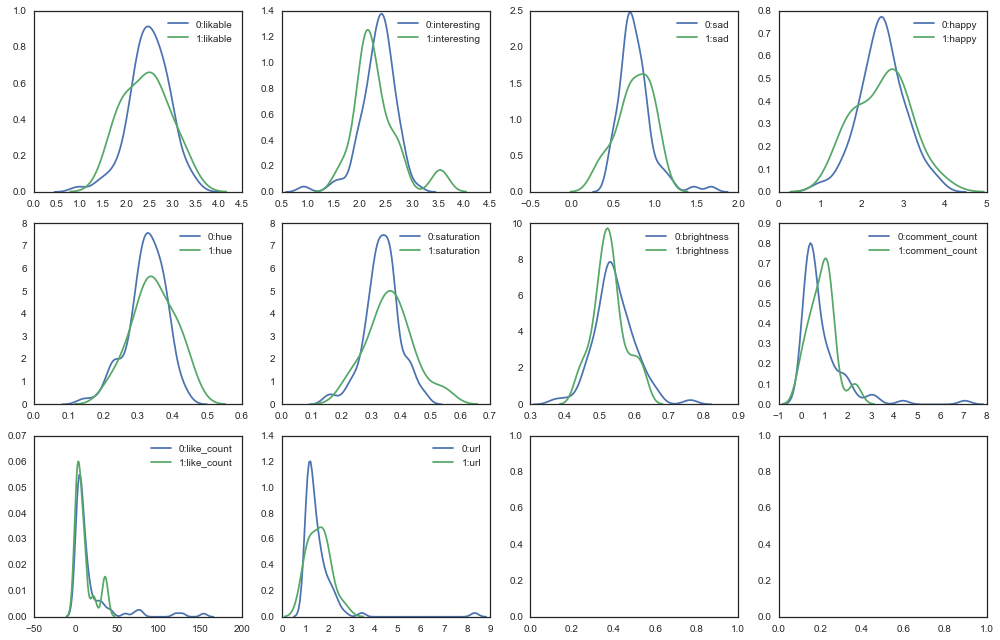

Correlation matrix:


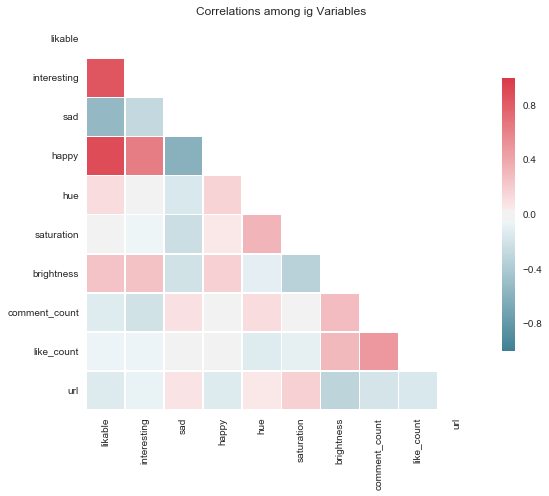

Building ML models...

UNIT OF OBSERVATION: USERNAME
NAIVE ACCURACY ALL NULL: 0.862
  *'ALL NULL' means if all observations are predicted as uncompleted assessments


MODEL: Logistic Regression target (Models: before_from_susp username):
NAIVE ACCURACY: 0.724

CONFUSION MATRIX (lr):
               pred_control  pred_target
known_control            20            5
known_target              3            1

Proportion of pred_target in known_control: 0.2
Proportion of pred_target in known_target: 0.25




/Users/andrew/anaconda/lib/python2.7/site-packages/sklearn/utils/class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


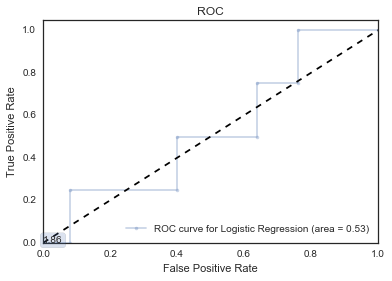

MODEL: Random Forests target (Models: before_from_susp username):
NAIVE ACCURACY: 0.793

CONFUSION MATRIX (rf):
               pred_control  pred_target
known_control            23            2
known_target              4            0

Proportion of pred_target in known_control: 0.08
Proportion of pred_target in known_target: 0.0




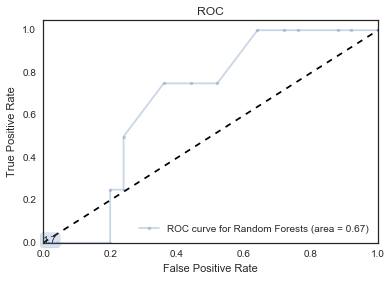

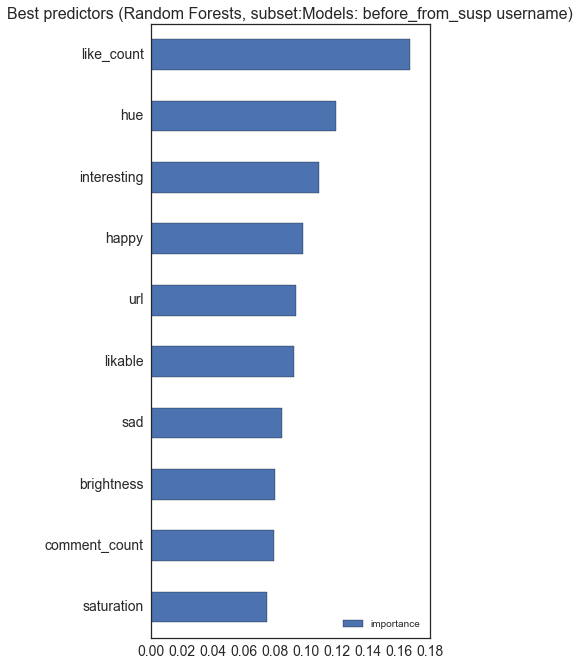


TTEST
UNIT OF MEASUREMENT: username

RATING: likable
Ttest_indResult(statistic=0.54443193799455813, pvalue=0.58743347574823812)

RATING: interesting
Ttest_indResult(statistic=0.34721295493847826, pvalue=0.72920751546120932)

RATING: sad
Ttest_indResult(statistic=0.16615750033670779, pvalue=0.86838987256101907)

RATING: happy
Ttest_indResult(statistic=-0.0012692961799221597, pvalue=0.99898993830869909)

RATING: hue
Ttest_indResult(statistic=-1.2360322045336252, pvalue=0.21952641235797066)

RATING: saturation
Ttest_indResult(statistic=-1.4978664924758813, pvalue=0.13751857407658247)

RATING: brightness
Ttest_indResult(statistic=0.84896985902425626, pvalue=0.39805495824986303)

RATING: comment_count
Ttest_indResult(statistic=-0.17989676085079143, pvalue=0.85762501743761099)

RATING: like_count
Ttest_indResult(statistic=0.80224622595659567, pvalue=0.42445583269641418)

RATING: url
Ttest_indResult(statistic=-0.2849090486815305, pvalue=0.77634731856405281)

bonferroni-corrected alpha of 0.0

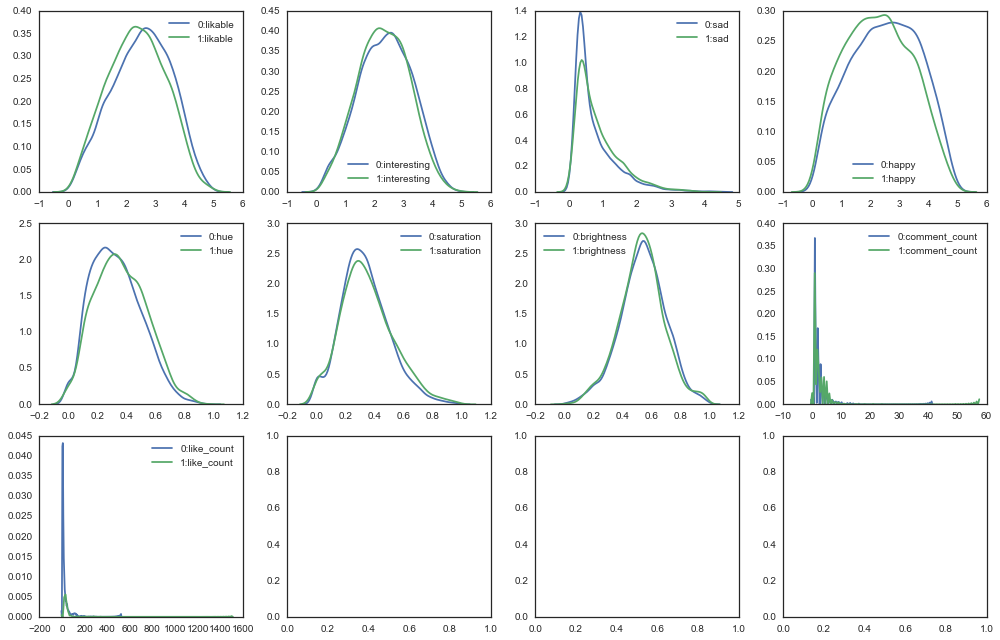

Correlation matrix:


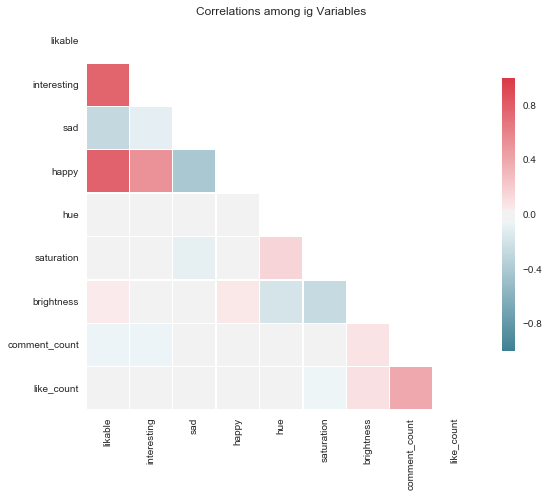

Building ML models...

UNIT OF OBSERVATION: POST
NAIVE ACCURACY ALL NULL: 0.738
  *'ALL NULL' means if all observations are predicted as uncompleted assessments


MODEL: Logistic Regression target (Models: after_from_diag post):
NAIVE ACCURACY: 0.558

CONFUSION MATRIX (lr):
               pred_control  pred_target
known_control          1192          986
known_target            318          455

Proportion of pred_target in known_control: 0.453
Proportion of pred_target in known_target: 0.589




/Users/andrew/anaconda/lib/python2.7/site-packages/sklearn/utils/class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


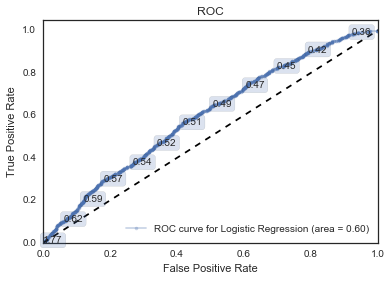

MODEL: Random Forests target (Models: after_from_diag post):
NAIVE ACCURACY: 0.733

CONFUSION MATRIX (rf):
               pred_control  pred_target
known_control          2090           88
known_target            699           74

Proportion of pred_target in known_control: 0.04
Proportion of pred_target in known_target: 0.096




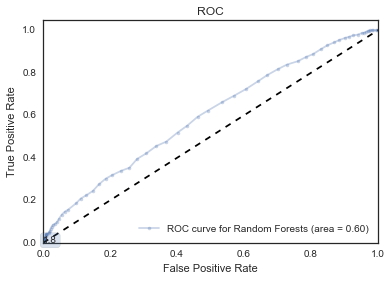

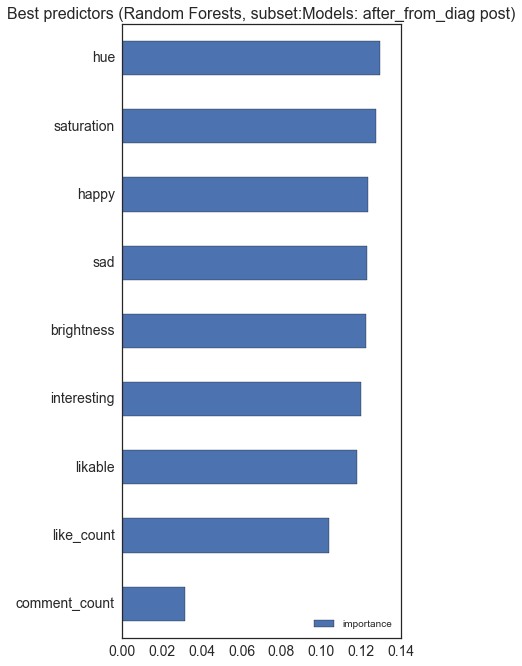


TTEST
UNIT OF MEASUREMENT: post

RATING: likable
Ttest_indResult(statistic=7.3711458663669411, pvalue=1.8280517697502732e-13)

RATING: interesting
Ttest_indResult(statistic=3.1905524883059933, pvalue=0.0014244720436123865)

RATING: sad
Ttest_indResult(statistic=-6.7237438369587439, pvalue=1.8696436711859342e-11)

RATING: happy
Ttest_indResult(statistic=8.971713732820529, pvalue=3.4535465749739969e-19)

RATING: hue
Ttest_indResult(statistic=-8.448628017803248, pvalue=3.37303761178109e-17)

RATING: saturation
Ttest_indResult(statistic=-4.0789395448530144, pvalue=4.5604931451118878e-05)

RATING: brightness
Ttest_indResult(statistic=2.5174920176767186, pvalue=0.011835409070432958)

RATING: comment_count
Ttest_indResult(statistic=0.059979118251372837, pvalue=0.95217603130891704)

RATING: like_count
Ttest_indResult(statistic=4.560993010799784, pvalue=5.2852108927296375e-06)

bonferroni-corrected alpha of 0.05: 0.00555555555556
likable significant post-correction? True (1.64524659278e-12)
in

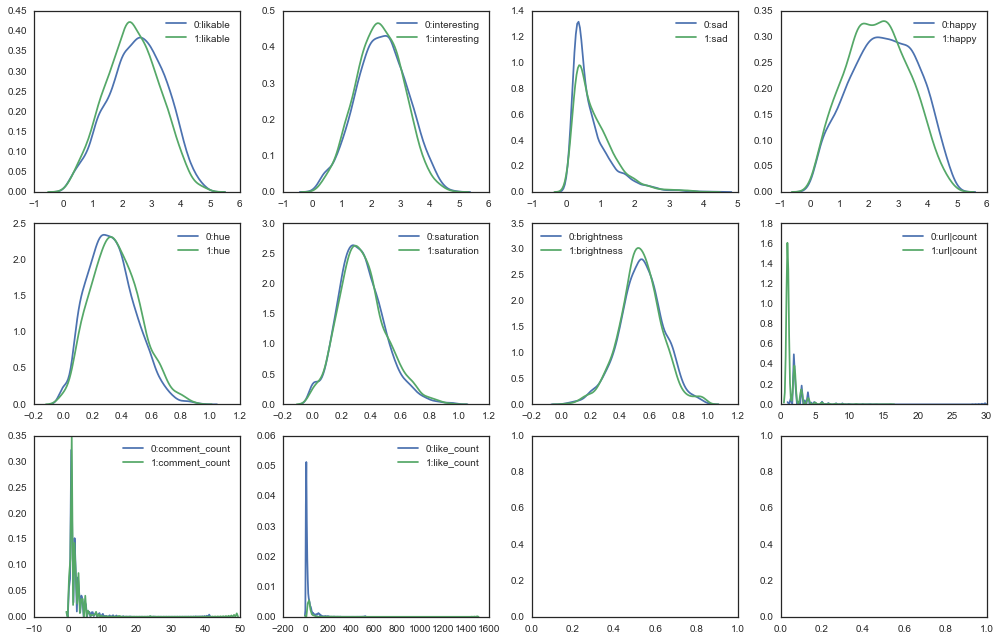

Correlation matrix:


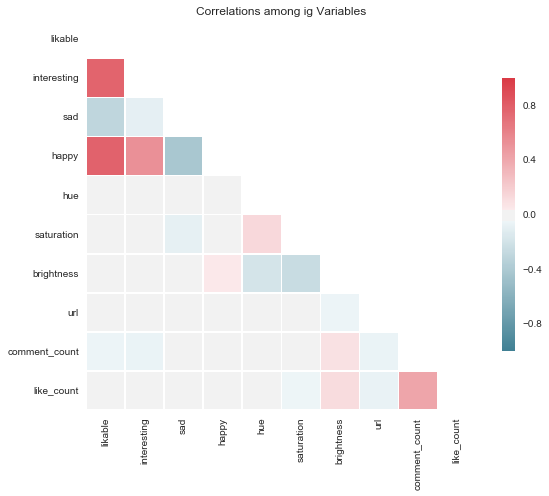

Building ML models...

UNIT OF OBSERVATION: CREATED_DATE
NAIVE ACCURACY ALL NULL: 0.741
  *'ALL NULL' means if all observations are predicted as uncompleted assessments


MODEL: Logistic Regression target (Models: after_from_diag created_date):
NAIVE ACCURACY: 0.577

CONFUSION MATRIX (lr):
               pred_control  pred_target
known_control           882          628
known_target            235          294

Proportion of pred_target in known_control: 0.416
Proportion of pred_target in known_target: 0.556




/Users/andrew/anaconda/lib/python2.7/site-packages/sklearn/utils/class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


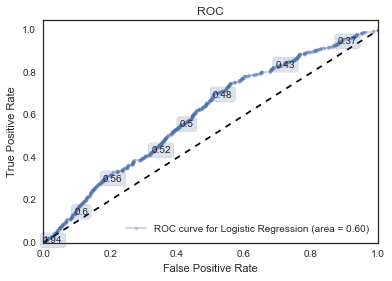

MODEL: Random Forests target (Models: after_from_diag created_date):
NAIVE ACCURACY: 0.737

CONFUSION MATRIX (rf):
               pred_control  pred_target
known_control          1474           36
known_target            501           28

Proportion of pred_target in known_control: 0.024
Proportion of pred_target in known_target: 0.053




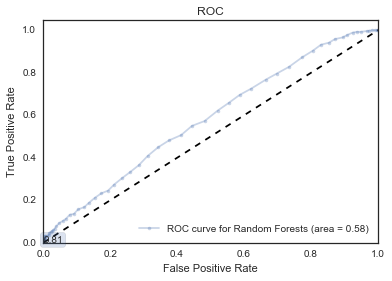

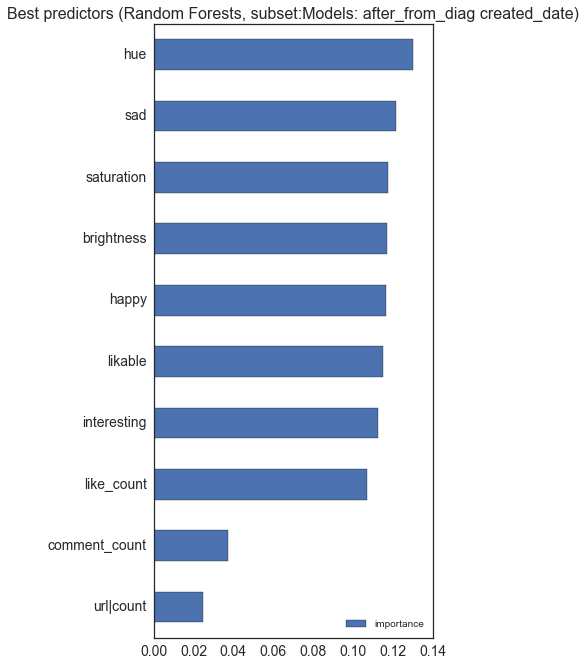


TTEST
UNIT OF MEASUREMENT: created_date

RATING: likable
Ttest_indResult(statistic=6.1484422136837029, pvalue=8.2683737683004943e-10)

RATING: interesting
Ttest_indResult(statistic=3.2363349553466745, pvalue=0.0012165574292508727)

RATING: sad
Ttest_indResult(statistic=-5.2781798350965081, pvalue=1.3451644832426507e-07)

RATING: happy
Ttest_indResult(statistic=7.1405688099740319, pvalue=1.0261305721544314e-12)

RATING: hue
Ttest_indResult(statistic=-6.6100061458636965, pvalue=4.1384353976082967e-11)

RATING: saturation
Ttest_indResult(statistic=-1.9550121143820711, pvalue=0.050623111153987377)

RATING: brightness
Ttest_indResult(statistic=1.9019030948288973, pvalue=0.057226620397921445)

RATING: url|count
Ttest_indResult(statistic=-4.1417990298974354, pvalue=3.4882220591690214e-05)

RATING: comment_count
Ttest_indResult(statistic=2.2333047914647097, pvalue=0.025608448002910889)

RATING: like_count
Ttest_indResult(statistic=4.7198403028756211, pvalue=2.4782182979185793e-06)

bonferroni

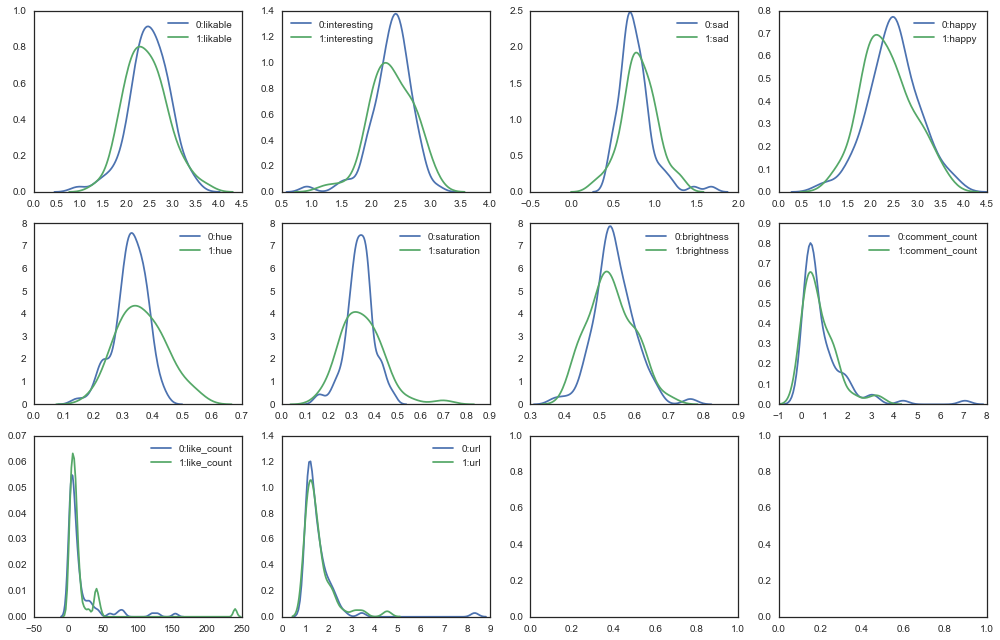

Correlation matrix:


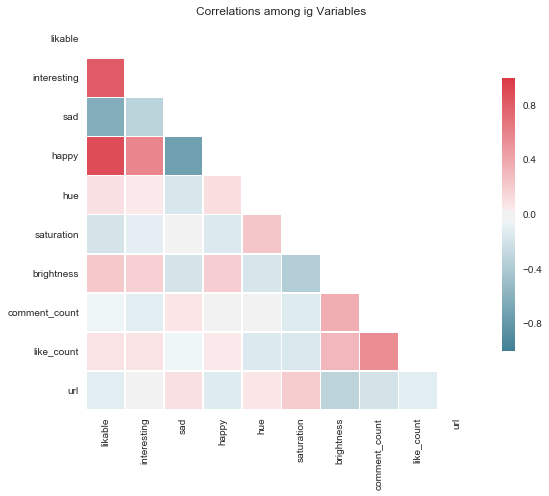

Building ML models...

UNIT OF OBSERVATION: USERNAME
NAIVE ACCURACY ALL NULL: 0.575
  *'ALL NULL' means if all observations are predicted as uncompleted assessments


MODEL: Logistic Regression target (Models: after_from_diag username):
NAIVE ACCURACY: 0.45

CONFUSION MATRIX (lr):
               pred_control  pred_target
known_control             9           14
known_target              8            9

Proportion of pred_target in known_control: 0.609
Proportion of pred_target in known_target: 0.529




/Users/andrew/anaconda/lib/python2.7/site-packages/sklearn/utils/class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


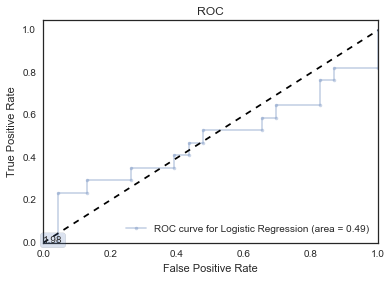

MODEL: Random Forests target (Models: after_from_diag username):
NAIVE ACCURACY: 0.6

CONFUSION MATRIX (rf):
               pred_control  pred_target
known_control            14            9
known_target              7           10

Proportion of pred_target in known_control: 0.391
Proportion of pred_target in known_target: 0.588




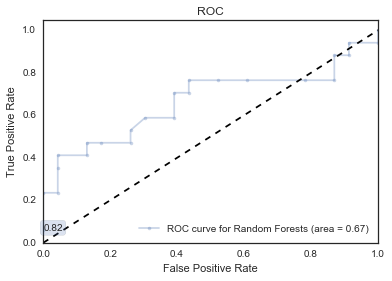

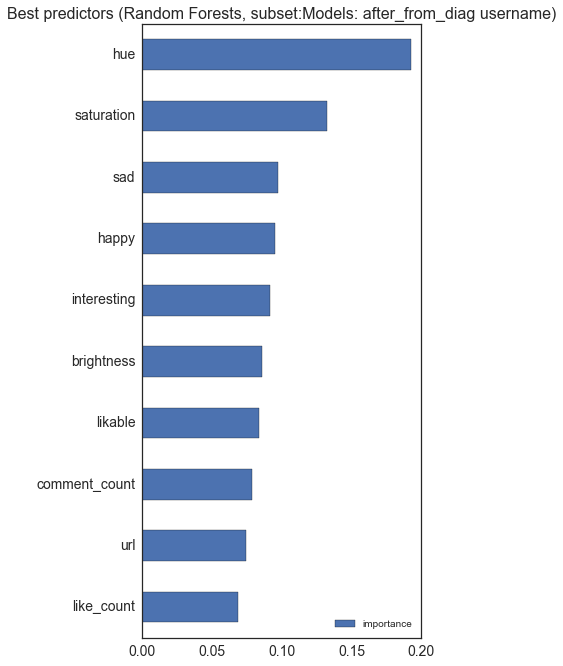


TTEST
UNIT OF MEASUREMENT: username

RATING: likable
Ttest_indResult(statistic=0.84835950426679296, pvalue=0.39779715912534386)

RATING: interesting
Ttest_indResult(statistic=0.026644291530409613, pvalue=0.9787843038620212)

RATING: sad
Ttest_indResult(statistic=-1.3019006833233024, pvalue=0.19525248528029426)

RATING: happy
Ttest_indResult(statistic=1.4078463883527839, pvalue=0.16156334138556391)

RATING: hue
Ttest_indResult(statistic=-3.1101328238441357, pvalue=0.0022985929866550982)

RATING: saturation
Ttest_indResult(statistic=-0.70147023536850173, pvalue=0.48426345380638625)

RATING: brightness
Ttest_indResult(statistic=0.87869628976008451, pvalue=0.38118719866290973)

RATING: comment_count
Ttest_indResult(statistic=0.48133823559733374, pvalue=0.63109797277404145)

RATING: like_count
Ttest_indResult(statistic=0.18732827515529268, pvalue=0.85169987002158187)

RATING: url
Ttest_indResult(statistic=-0.069239481795733346, pvalue=0.94490704790923208)

bonferroni-corrected alpha of 0.0

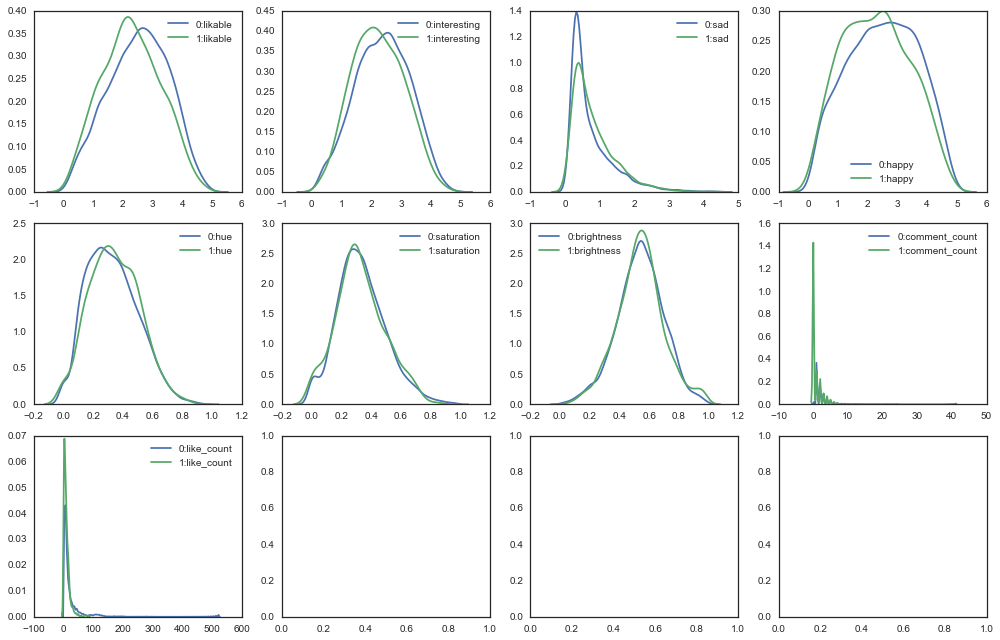

Correlation matrix:


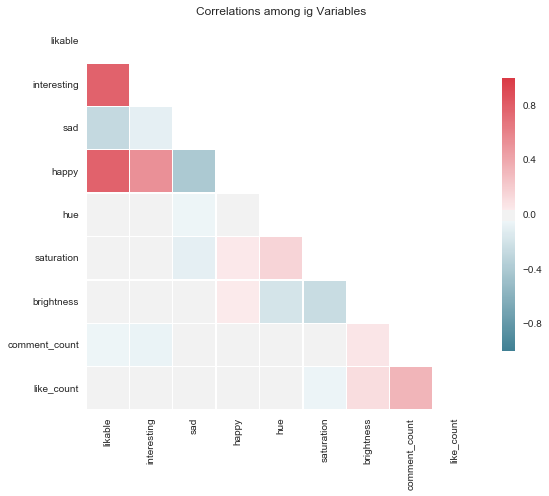

Building ML models...

UNIT OF OBSERVATION: POST
NAIVE ACCURACY ALL NULL: 0.858
  *'ALL NULL' means if all observations are predicted as uncompleted assessments


MODEL: Logistic Regression target (Models: after_from_susp post):
NAIVE ACCURACY: 0.54

CONFUSION MATRIX (lr):
               pred_control  pred_target
known_control          1099         1027
known_target            112          240

Proportion of pred_target in known_control: 0.483
Proportion of pred_target in known_target: 0.682




/Users/andrew/anaconda/lib/python2.7/site-packages/sklearn/utils/class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


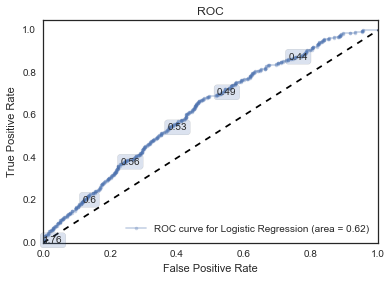

MODEL: Random Forests target (Models: after_from_susp post):
NAIVE ACCURACY: 0.857

CONFUSION MATRIX (rf):
               pred_control  pred_target
known_control          2122            4
known_target            350            2

Proportion of pred_target in known_control: 0.002
Proportion of pred_target in known_target: 0.006




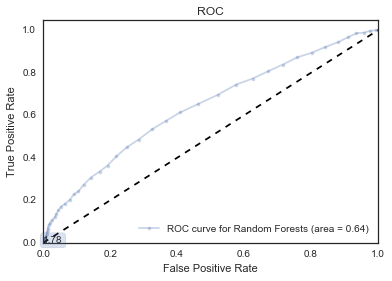

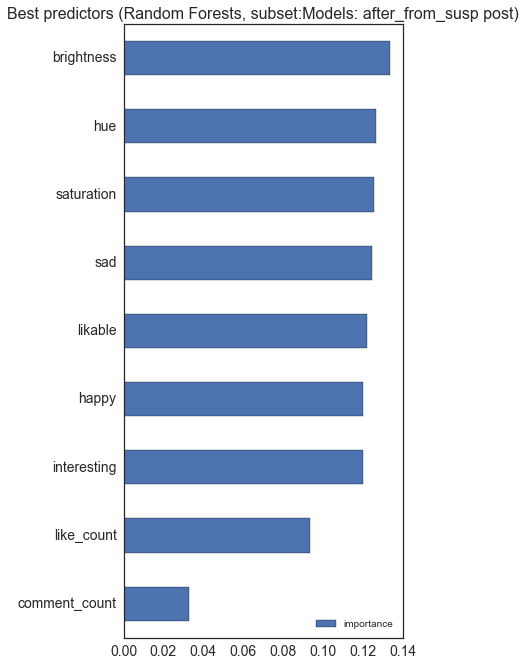


TTEST
UNIT OF MEASUREMENT: post

RATING: likable
Ttest_indResult(statistic=7.456528225980958, pvalue=9.7835866636332708e-14)

RATING: interesting
Ttest_indResult(statistic=4.9476577150138432, pvalue=7.6596411760235754e-07)

RATING: sad
Ttest_indResult(statistic=-3.4761335054815481, pvalue=0.00051131843424544632)

RATING: happy
Ttest_indResult(statistic=5.9268046570197663, pvalue=3.2129888577066537e-09)

RATING: hue
Ttest_indResult(statistic=-3.3798538804976608, pvalue=0.00072866785822912037)

RATING: saturation
Ttest_indResult(statistic=0.87202125851285928, pvalue=0.38322262373735816)

RATING: brightness
Ttest_indResult(statistic=0.17095687582476002, pvalue=0.86426194401424594)

RATING: comment_count
Ttest_indResult(statistic=-0.25464735450335524, pvalue=0.79901495302811476)

RATING: like_count
Ttest_indResult(statistic=7.6437861832314997, pvalue=2.9251242210775264e-14)

bonferroni-corrected alpha of 0.05: 0.00555555555556
likable significant post-correction? True (8.80522799727e-13)


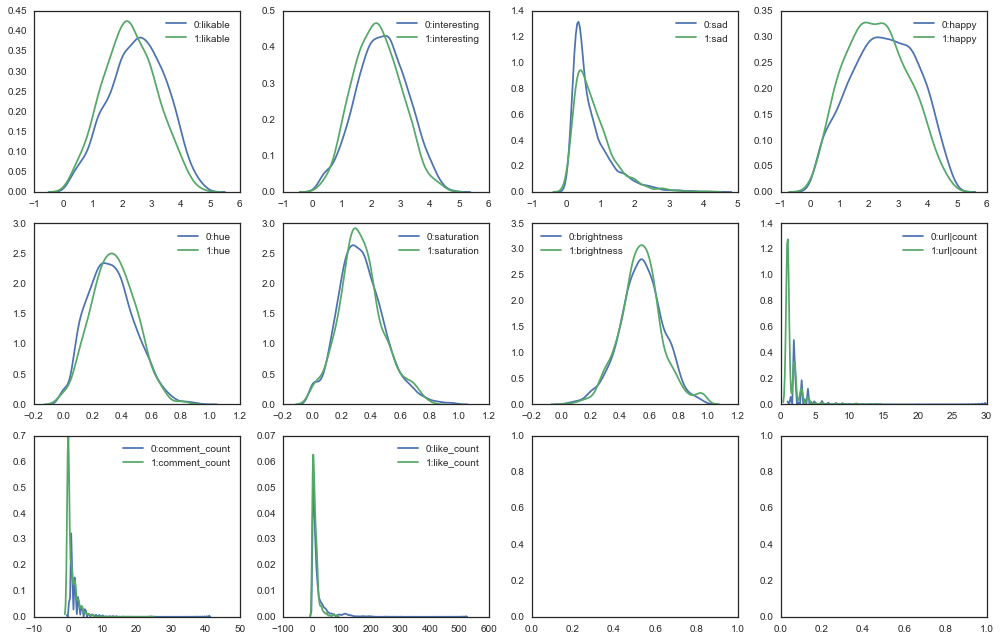

Correlation matrix:


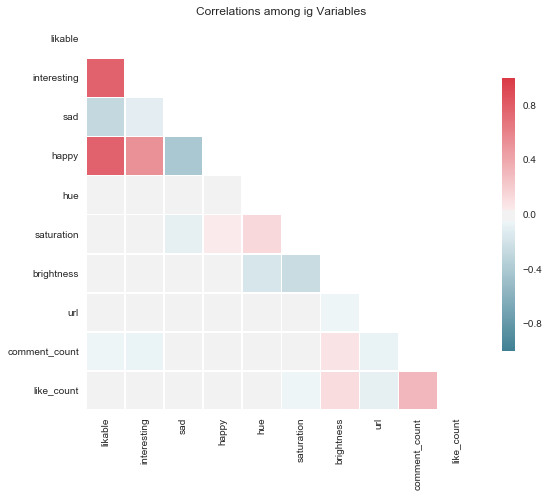

Building ML models...

UNIT OF OBSERVATION: CREATED_DATE
NAIVE ACCURACY ALL NULL: 0.874
  *'ALL NULL' means if all observations are predicted as uncompleted assessments


MODEL: Logistic Regression target (Models: after_from_susp created_date):
NAIVE ACCURACY: 0.557

CONFUSION MATRIX (lr):
               pred_control  pred_target
known_control           826          689
known_target             78          140

Proportion of pred_target in known_control: 0.455
Proportion of pred_target in known_target: 0.642




/Users/andrew/anaconda/lib/python2.7/site-packages/sklearn/utils/class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


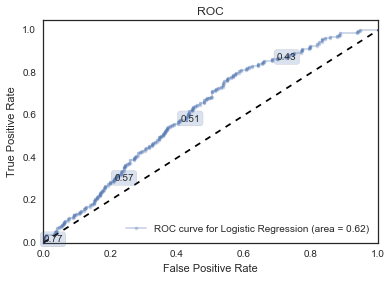

MODEL: Random Forests target (Models: after_from_susp created_date):
NAIVE ACCURACY: 0.874

CONFUSION MATRIX (rf):
               pred_control  pred_target
known_control          1511            4
known_target            215            3

Proportion of pred_target in known_control: 0.003
Proportion of pred_target in known_target: 0.014




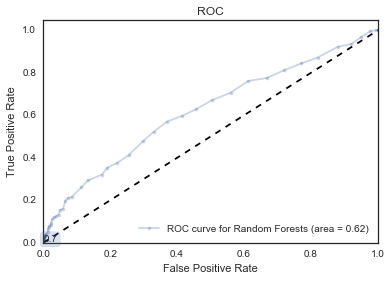

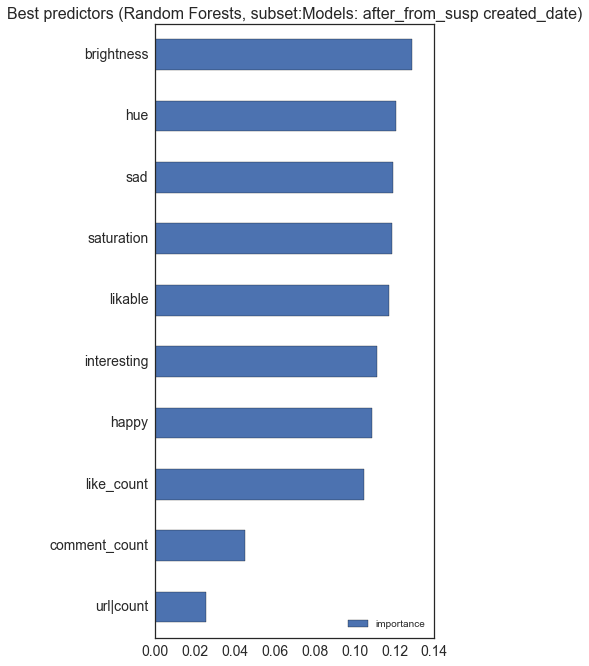


TTEST
UNIT OF MEASUREMENT: created_date

RATING: likable
Ttest_indResult(statistic=6.8043290972669856, pvalue=1.1178117507814333e-11)

RATING: interesting
Ttest_indResult(statistic=4.5668497909825794, pvalue=5.053932845408106e-06)

RATING: sad
Ttest_indResult(statistic=-2.8300957967803981, pvalue=0.004669486077834635)

RATING: happy
Ttest_indResult(statistic=5.5901722961638782, pvalue=2.3724251005956424e-08)

RATING: hue
Ttest_indResult(statistic=-2.7577638788544685, pvalue=0.0058383782735079142)

RATING: saturation
Ttest_indResult(statistic=-0.023701851995715187, pvalue=0.98109125898505045)

RATING: brightness
Ttest_indResult(statistic=0.69975520785301926, pvalue=0.48410876809789694)

RATING: url|count
Ttest_indResult(statistic=-3.1220093509693414, pvalue=0.0018052097214678253)

RATING: comment_count
Ttest_indResult(statistic=1.1549529704245716, pvalue=0.2482267113145826)

RATING: like_count
Ttest_indResult(statistic=6.969784601943628, pvalue=4.1103305620613049e-12)

bonferroni-corre

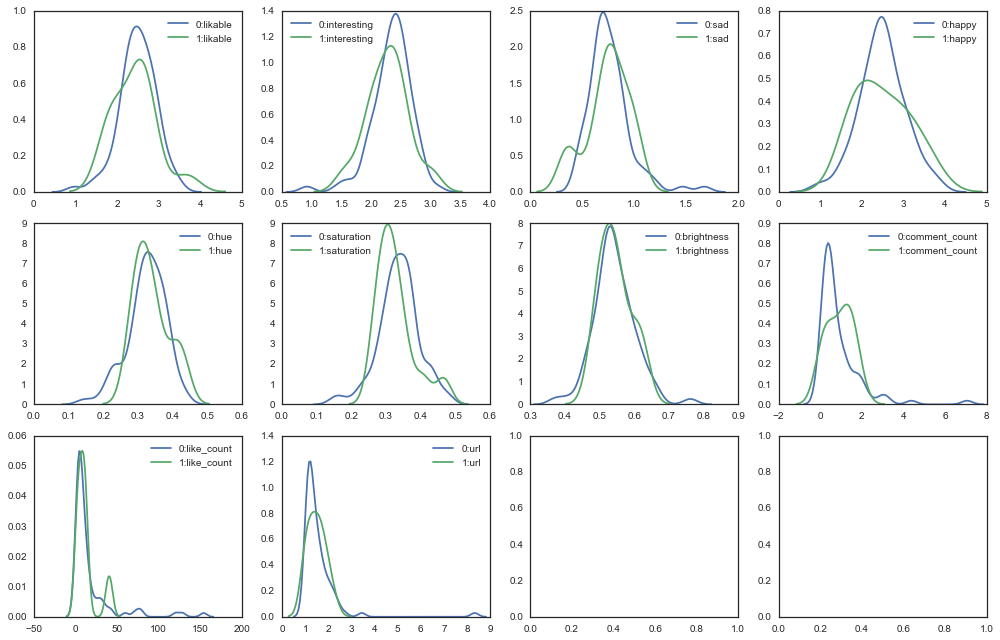

Correlation matrix:


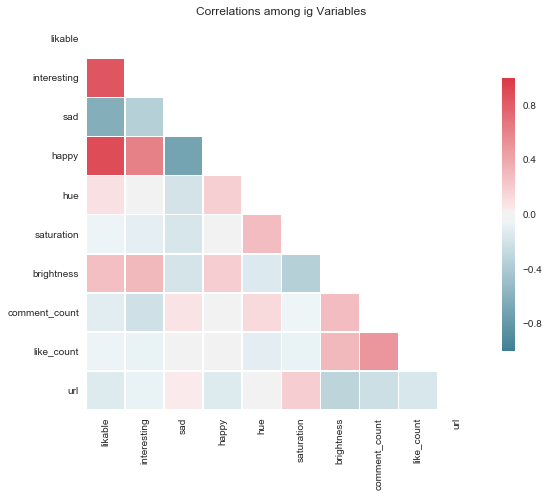

Building ML models...

UNIT OF OBSERVATION: USERNAME
NAIVE ACCURACY ALL NULL: 0.793
  *'ALL NULL' means if all observations are predicted as uncompleted assessments


MODEL: Logistic Regression target (Models: after_from_susp username):
NAIVE ACCURACY: 0.517

CONFUSION MATRIX (lr):
               pred_control  pred_target
known_control            14            9
known_target              5            1

Proportion of pred_target in known_control: 0.391
Proportion of pred_target in known_target: 0.167




/Users/andrew/anaconda/lib/python2.7/site-packages/sklearn/utils/class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


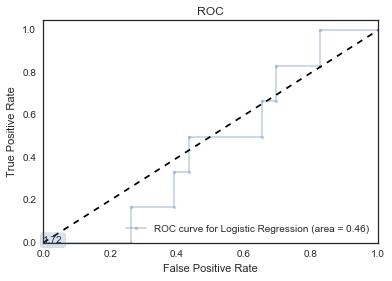

MODEL: Random Forests target (Models: after_from_susp username):
NAIVE ACCURACY: 0.793

CONFUSION MATRIX (rf):
               pred_control  pred_target
known_control            23            0
known_target              6            0

Proportion of pred_target in known_control: 0.0
Proportion of pred_target in known_target: 0.0




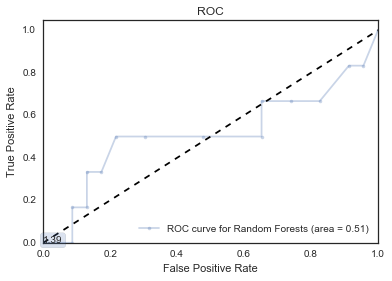

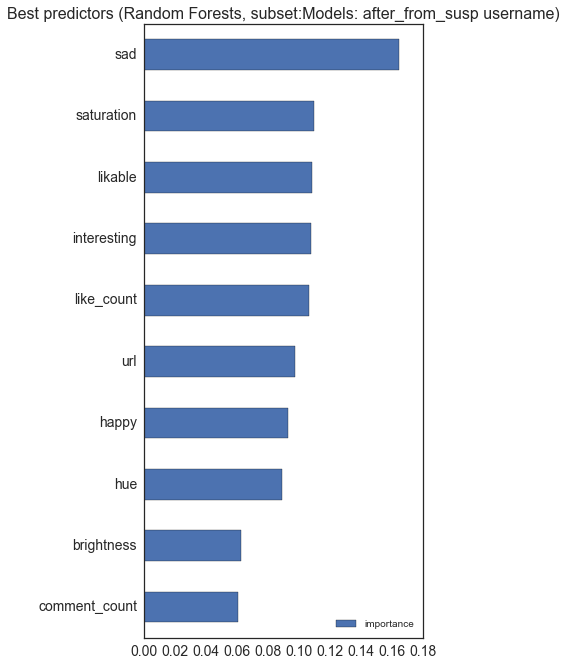


TTEST
UNIT OF MEASUREMENT: username

RATING: likable
Ttest_indResult(statistic=0.54247671073821835, pvalue=0.58877398172114259)

RATING: interesting
Ttest_indResult(statistic=0.72353080862609309, pvalue=0.47115051659660523)

RATING: sad
Ttest_indResult(statistic=0.27148612900238517, pvalue=0.78661250214316547)

RATING: happy
Ttest_indResult(statistic=-0.078043276986544216, pvalue=0.93795951566123459)

RATING: hue
Ttest_indResult(statistic=-0.89131087635399864, pvalue=0.37503821960337402)

RATING: saturation
Ttest_indResult(statistic=0.59090784021668452, pvalue=0.55600034974582291)

RATING: brightness
Ttest_indResult(statistic=-0.1539562703181194, pvalue=0.87797426686789981)

RATING: comment_count
Ttest_indResult(statistic=-0.076943955623607757, pvalue=0.93883166696457088)

RATING: like_count
Ttest_indResult(statistic=0.71096137683509431, pvalue=0.47886859333970266)

RATING: url
Ttest_indResult(statistic=0.30150699488776039, pvalue=0.76369391048146351)

bonferroni-corrected alpha of 0.

In [13]:
use_pca = False # should models be fit using orthogonal pca components?

if run_subsets:
    action_params['compare_filters'] = False
    for period in periods:
        if action_params['create_master']:
            data['master'][period] = {}

        for turn_point in turn_points:    
            if action_params['create_master']:
                data['master'][period][turn_point] = {}

            master = data['master'][period][turn_point]
            target = data['target'][period][turn_point]['gb']
            control = data['control']['gb'] 
            report = '{}_{}'.format(period,turn_point)

            if action_params['create_master']:
                master['model'] = {}

            for gb_type in gb_types:
                print 'Reporting for: SUBSETS'
                print 'Period: {}  Focus: {}  Groupby: {}'.format(period.upper(), turn_point.upper(), gb_type.upper())
                # merge target, control, into master
                master_actions(master, target, control, condition,
                               platform, params, gb_type, report,
                               action_params, clfs, additional_data,
                               use_pca=use_pca) # using PCA?

### Pickle entire data dict

Set final_pickle = True to save to disk  
Note that this is separate from saving individual files to csv, which is controlled by the save_to_file flag in action_params.

In [9]:
if final_pickle:
    pickle.dump( data, open( "{cond}_{pl}_data.p".format(cond=condition,pl=platform), "wb" ) )

### Within-target before vs after

This compares before/after diag/susp dates within target population.  
Basically just a check to see whether the population looks different based on a given change point


before vs after (target: depression) for created_date-groupby, based on diag_date:


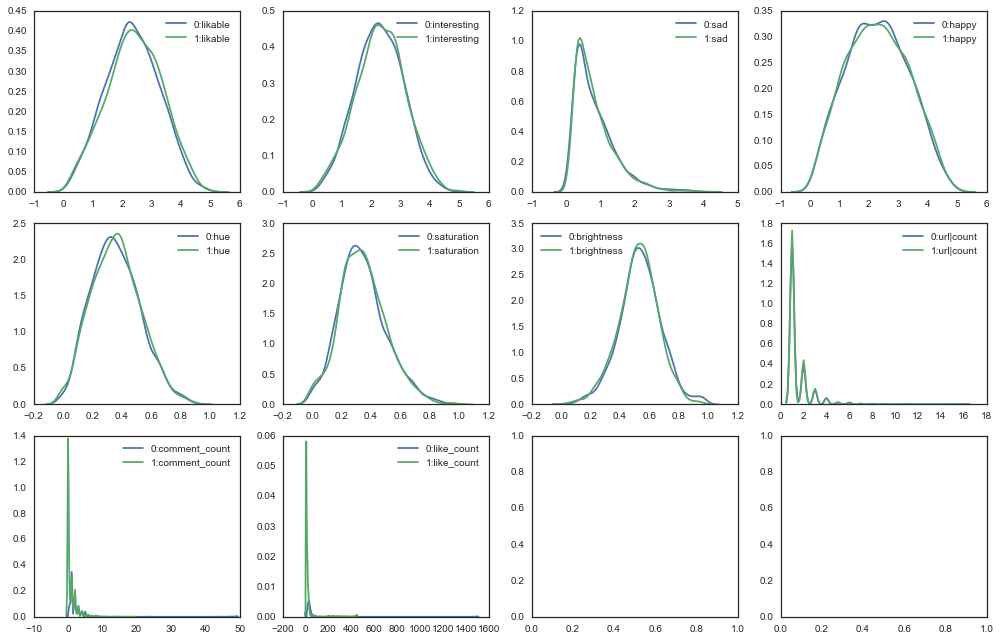

UNIT OF MEASUREMENT: created_date

RATING: likable
Ttest_indResult(statistic=-2.3992759940550998, pvalue=0.016473747031739507)

RATING: interesting
Ttest_indResult(statistic=-1.6852843493195804, pvalue=0.092012993331664503)

RATING: sad
Ttest_indResult(statistic=0.67201955701244465, pvalue=0.50161068909795747)

RATING: happy
Ttest_indResult(statistic=-0.28128727955842087, pvalue=0.77850485202464503)

RATING: hue
Ttest_indResult(statistic=-0.90489522760830243, pvalue=0.36557702086935862)

RATING: saturation
Ttest_indResult(statistic=-1.0811294599180936, pvalue=0.27970665274804468)

RATING: brightness
Ttest_indResult(statistic=3.3123868259217613, pvalue=0.00093349946034082683)

RATING: url|count
Ttest_indResult(statistic=0.35200582017870852, pvalue=0.72485299437620099)

RATING: comment_count
Ttest_indResult(statistic=1.4190574841091832, pvalue=0.15607251130565325)

RATING: like_count
Ttest_indResult(statistic=-2.2592287203949146, pvalue=0.02400076612686482)

bonferroni-corrected alpha of

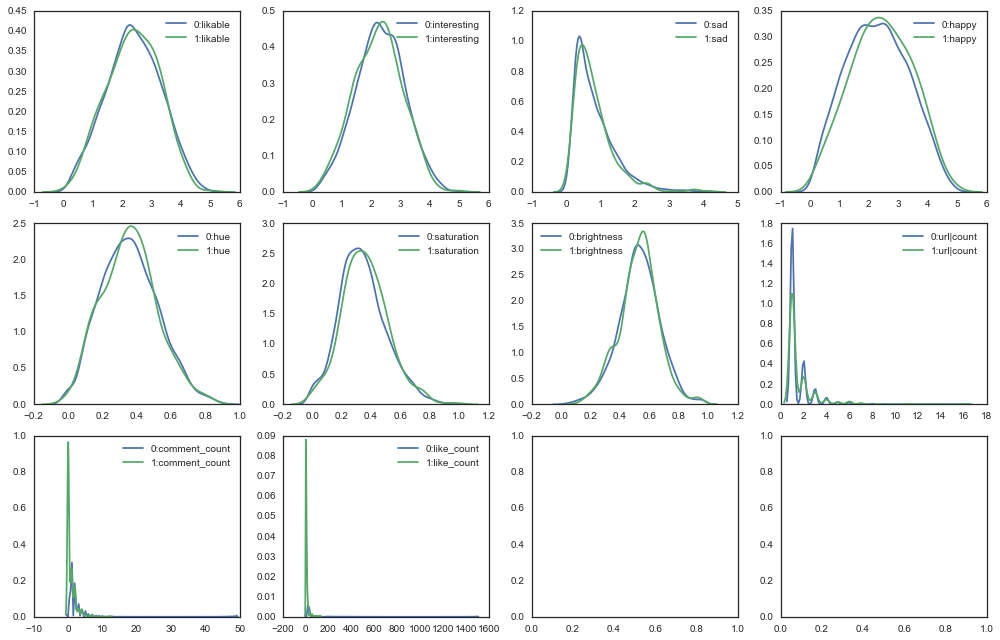

UNIT OF MEASUREMENT: created_date

RATING: likable
Ttest_indResult(statistic=0.30765366191839566, pvalue=0.75836216069843665)

RATING: interesting
Ttest_indResult(statistic=1.7668591646166909, pvalue=0.077329304409296404)

RATING: sad
Ttest_indResult(statistic=0.64915093591059925, pvalue=0.51627869711350638)

RATING: happy
Ttest_indResult(statistic=-2.6723766097547954, pvalue=0.0075626557444276165)

RATING: hue
Ttest_indResult(statistic=0.28615691113709912, pvalue=0.77477320554970674)

RATING: saturation
Ttest_indResult(statistic=-1.9440002500581119, pvalue=0.05196754107113799)

RATING: brightness
Ttest_indResult(statistic=0.4759212380151131, pvalue=0.63415725822775104)

RATING: url|count
Ttest_indResult(statistic=-1.8381378465611851, pvalue=0.066118419298778403)

RATING: comment_count
Ttest_indResult(statistic=1.0228782527273406, pvalue=0.30651645275473516)

RATING: like_count
Ttest_indResult(statistic=2.4426091242133681, pvalue=0.014687090863419757)

bonferroni-corrected alpha of 0.0

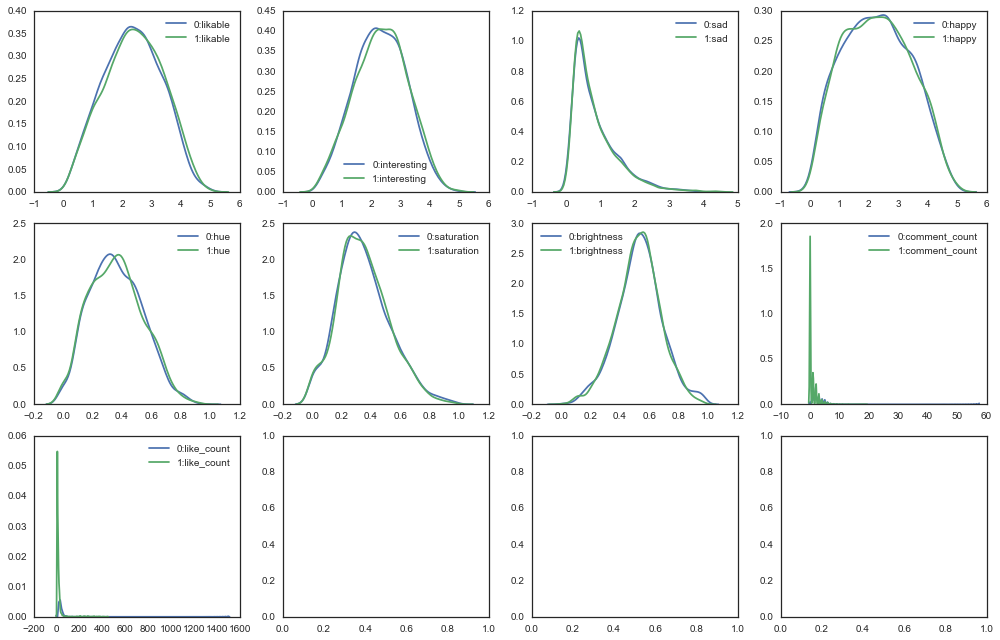

UNIT OF MEASUREMENT: post

RATING: likable
Ttest_indResult(statistic=-2.4630337947642698, pvalue=0.013804215989255577)

RATING: interesting
Ttest_indResult(statistic=-1.6788162150684924, pvalue=0.093239278989031185)

RATING: sad
Ttest_indResult(statistic=0.37591996211207113, pvalue=0.7069895257485006)

RATING: happy
Ttest_indResult(statistic=-0.44043527310763031, pvalue=0.65963755278821268)

RATING: hue
Ttest_indResult(statistic=-0.45413534480979917, pvalue=0.64974797163701781)

RATING: saturation
Ttest_indResult(statistic=-0.18234840834365154, pvalue=0.85531552009364908)

RATING: brightness
Ttest_indResult(statistic=1.6455699075563175, pvalue=0.099905130966330399)

RATING: comment_count
Ttest_indResult(statistic=1.9852173717890214, pvalue=0.047256818059873397)

RATING: like_count
Ttest_indResult(statistic=-2.6426438031502264, pvalue=0.0082910073008070143)

bonferroni-corrected alpha of 0.05: 0.00555555555556
likable significant post-correction? False (0.124237943903)
interesting signi

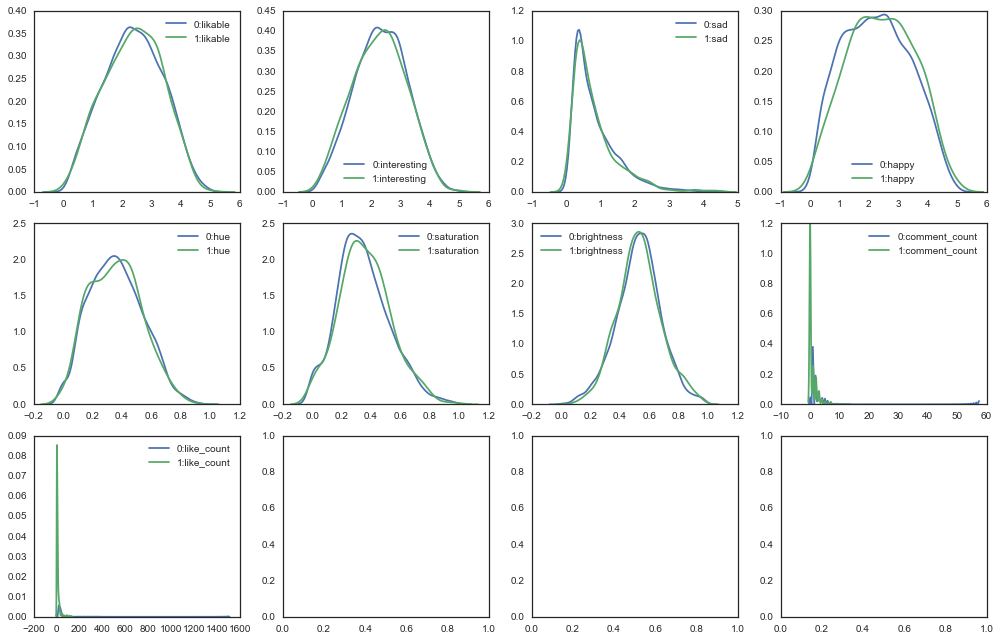

UNIT OF MEASUREMENT: post

RATING: likable
Ttest_indResult(statistic=0.11593827890200856, pvalue=0.90770528885758661)

RATING: interesting
Ttest_indResult(statistic=1.4999835386550768, pvalue=0.13367061471414382)

RATING: sad
Ttest_indResult(statistic=0.1297820137840133, pvalue=0.89674319017901594)

RATING: happy
Ttest_indResult(statistic=-3.2260015926437107, pvalue=0.0012619789067046352)

RATING: hue
Ttest_indResult(statistic=0.95936370610581856, pvalue=0.33741451404881351)

RATING: saturation
Ttest_indResult(statistic=-1.5329355903554946, pvalue=0.12534486462903491)

RATING: brightness
Ttest_indResult(statistic=-0.49223945768604199, pvalue=0.62256822550306534)

RATING: comment_count
Ttest_indResult(statistic=0.61527913729593586, pvalue=0.53844046457483952)

RATING: like_count
Ttest_indResult(statistic=2.7955834367587884, pvalue=0.0052306244334777499)

bonferroni-corrected alpha of 0.05: 0.00555555555556
likable significant post-correction? False (1.0)
interesting significant post-cor

In [9]:
# no username gb because you don't have the infrastructure built (you'd need to split bef/aft before the username gb)
# but at any rate, this is just a check...and per-username groupby has the lowest sample size anyhow

for gb_type in ['created_date','post']: 
    before_vs_after(data['target']['gb'], gb_type, platform, condition, 
                    params['vars'][platform], action_params, additional_data)

### PCA

PCA below only runs on master (ie. not before/after diag/susp vs control).

Note: You can fold in PCA into the master_actions() sequence, above, by adding the parameter use_pca=True  
This will only run PCA and PCA components as predictors, though.  
Currently you can't run both PCA and non-PCA when modeling, simulataneously - you did this mainly to cut down on the length of any one given code block output.  
You may find PCA particularly helpful for the timeline groups analysis...

RUNNING PCA: post

Total vars: 9
Num components selected by Minka MLE: 8
Cumulative % variance explained per component:
[ 28.11  45.53  59.6   70.44  79.84  87.68  94.31  98.52]


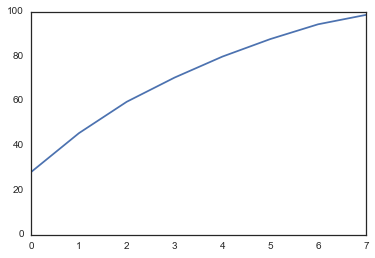

Num pca comp displayed: 8
Optimal number of components: 9
Optimal number based on F1 max exceeds Minka MLE...scaling back to Minka


/Users/andrew/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


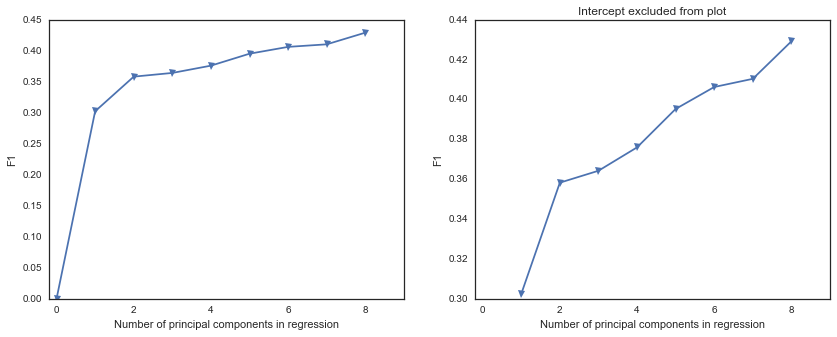

likable          0.592197
happy            0.553443
interesting      0.504211
sad              0.289847
brightness       0.048373
like_count       0.045301
comment_count    0.017047
hue              0.008233
saturation       0.003566
Name: PCA_0, dtype: float64

like_count       0.502928
brightness       0.488955
comment_count    0.459386
saturation       0.416042
hue              0.342788
sad              0.072319
happy            0.029010
likable          0.015552
interesting      0.006579
Name: PCA_1, dtype: float64

comment_count    0.542407
like_count       0.478725
saturation       0.421727
hue              0.421659
brightness       0.333276
sad              0.089104
interesting      0.035629
happy            0.019777
likable          0.017141
Name: PCA_2, dtype: float64


NOTE: ALL MODELS ON THIS RUN USE PCA COMPONENTS!

UNIT OF OBSERVATION: POST
NAIVE ACCURACY ALL NULL: 0.534
  *'ALL NULL' means if all observations are predicted as uncompleted assessments


MODEL: Logistic Regr

/Users/andrew/anaconda/lib/python2.7/site-packages/sklearn/utils/class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


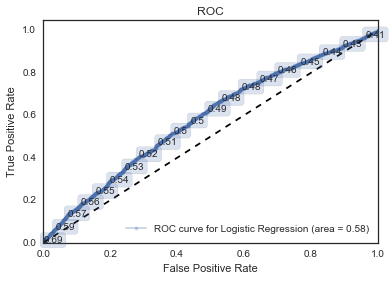

MODEL: Random Forests target (Models: PCA MAIN post):
NAIVE ACCURACY: 0.582

CONFUSION MATRIX (rf):
               pred_control  pred_target
known_control          1474          639
known_target           1016          826

Proportion of pred_target in known_control: 0.302
Proportion of pred_target in known_target: 0.448




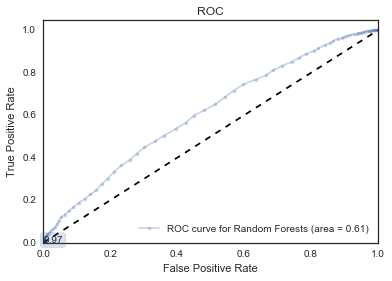

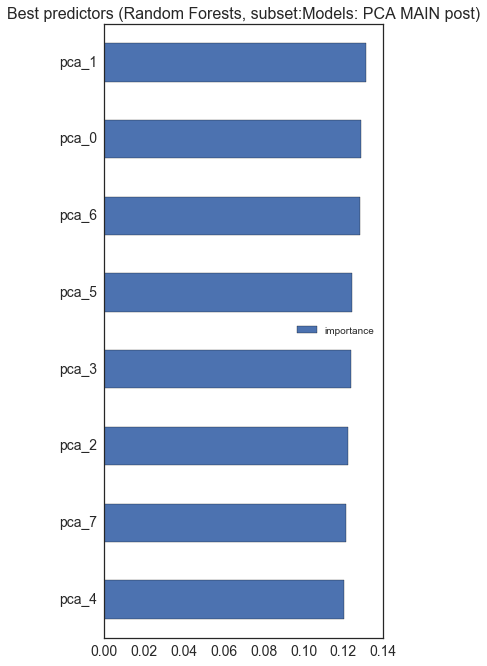

RUNNING PCA: created_date

Total vars: 10
Num components selected by Minka MLE: 9
Cumulative % variance explained per component:
[ 25.47  41.45  54.04  64.06  73.61  82.15  89.2   94.97  98.69]


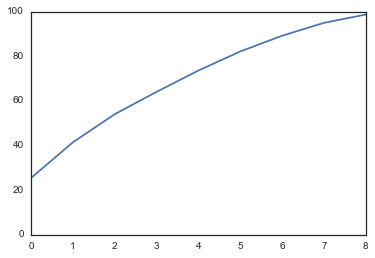

Num pca comp displayed: 9
Optimal number of components: 10
Optimal number based on F1 max exceeds Minka MLE...scaling back to Minka


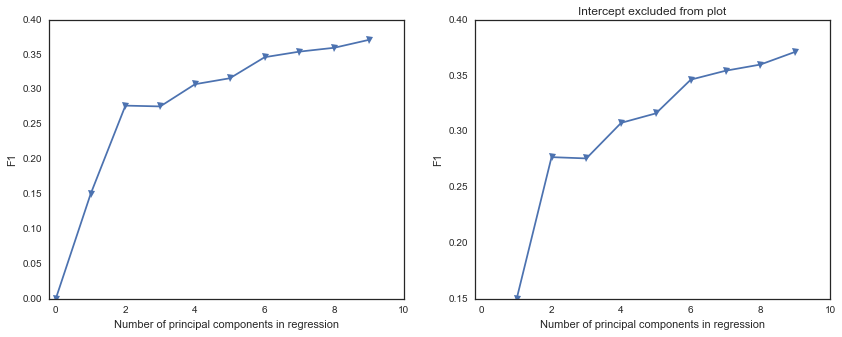

likable          0.590274
happy            0.552477
interesting      0.503860
sad              0.291270
like_count       0.060996
brightness       0.058305
saturation       0.016126
hue              0.013465
url|count        0.008368
comment_count    0.001381
Name: PCA_0, dtype: float64

like_count       0.530427
comment_count    0.485018
brightness       0.468214
saturation       0.375832
hue              0.306069
url|count        0.147411
sad              0.064278
happy            0.043333
likable          0.037145
interesting      0.011531
Name: PCA_1, dtype: float64

comment_count    0.506763
saturation       0.455597
hue              0.453781
like_count       0.421296
brightness       0.345713
sad              0.134386
interesting      0.079470
url|count        0.077125
happy            0.042166
likable          0.024439
Name: PCA_2, dtype: float64


NOTE: ALL MODELS ON THIS RUN USE PCA COMPONENTS!

UNIT OF OBSERVATION: CREATED_DATE
NAIVE ACCURACY ALL NULL: 0.576
  *'ALL NULL' mea

/Users/andrew/anaconda/lib/python2.7/site-packages/sklearn/utils/class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


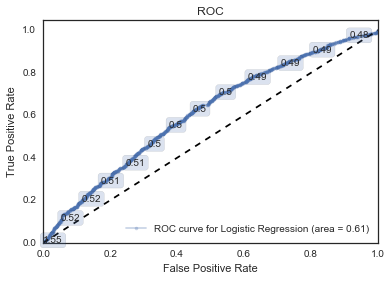

MODEL: Random Forests target (Models: PCA MAIN created_date):
NAIVE ACCURACY: 0.573

CONFUSION MATRIX (rf):
               pred_control  pred_target
known_control          1084          467
known_target            684          458

Proportion of pred_target in known_control: 0.301
Proportion of pred_target in known_target: 0.401




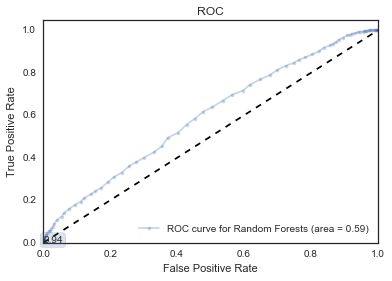

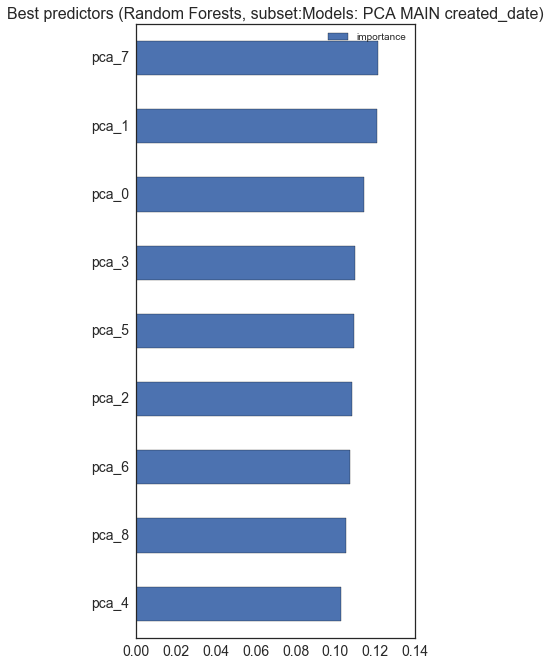

RUNNING PCA: username

Total vars: 10
Num components selected by Minka MLE: 9
Cumulative % variance explained per component:
[ 32.66  53.78  66.06  75.43  82.95  88.97  93.82  97.91  99.7 ]


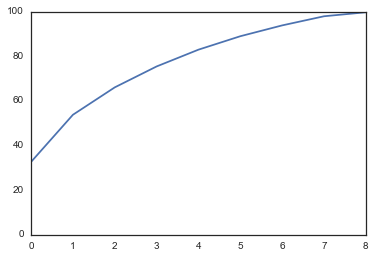

Num pca comp displayed: 9
Optimal number of components: 8


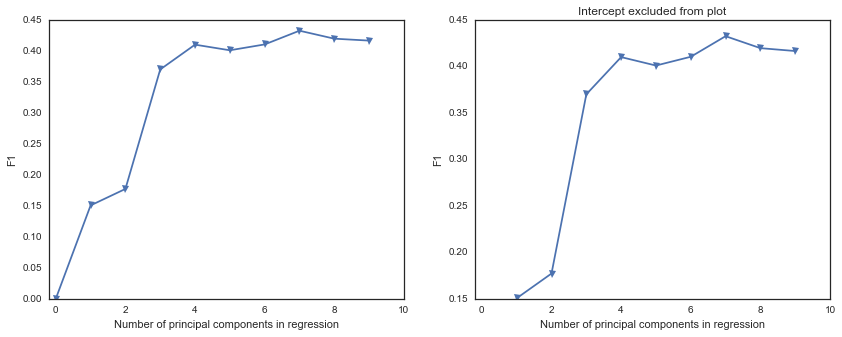

likable          0.511587
happy            0.487813
interesting      0.420639
sad              0.389796
brightness       0.302480
like_count       0.165441
saturation       0.159850
url              0.126191
comment_count    0.089685
hue              0.055267
Name: PCA_0, dtype: float64

comment_count    0.460983
like_count       0.453072
brightness       0.390818
saturation       0.373755
url              0.273458
hue              0.265529
sad              0.202013
likable          0.199998
happy            0.198750
interesting      0.155546
Name: PCA_1, dtype: float64

hue              0.620755
comment_count    0.494145
saturation       0.472018
like_count       0.315242
sad              0.144414
interesting      0.142720
happy            0.076684
likable          0.023848
brightness       0.021887
url              0.012334
Name: PCA_2, dtype: float64


NOTE: ALL MODELS ON THIS RUN USE PCA COMPONENTS!

UNIT OF OBSERVATION: USERNAME
NAIVE ACCURACY ALL NULL: 0.6
  *'ALL NULL' means if 

/Users/andrew/anaconda/lib/python2.7/site-packages/sklearn/utils/class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


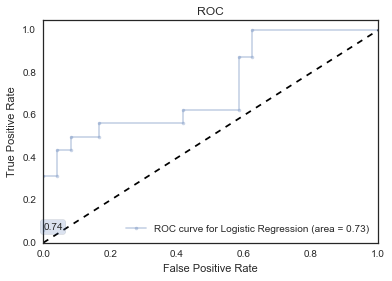

MODEL: Random Forests target (Models: PCA MAIN username):
NAIVE ACCURACY: 0.625

CONFUSION MATRIX (rf):
               pred_control  pred_target
known_control            19            5
known_target             10            6

Proportion of pred_target in known_control: 0.208
Proportion of pred_target in known_target: 0.375




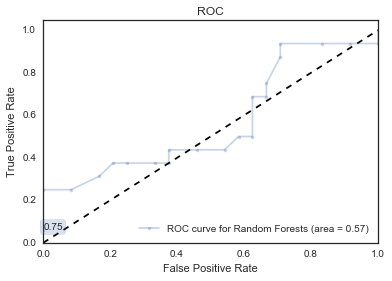

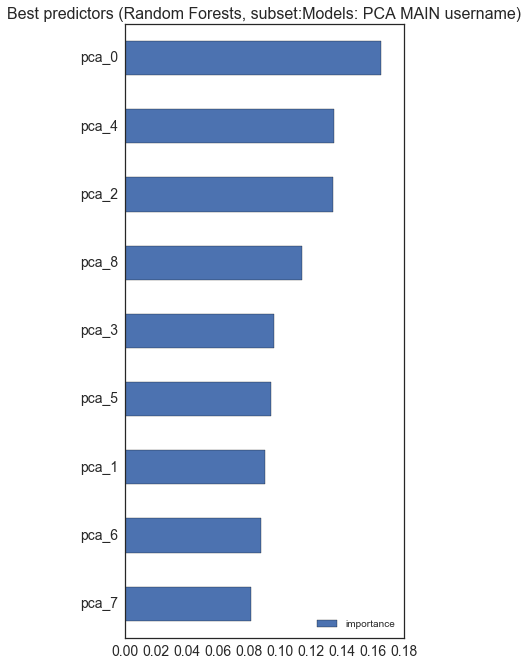

In [10]:
if run_separate_pca:
    master = data['master']
    report = 'PCA MAIN'

    for gb_type in gb_types:

        print 'RUNNING PCA: {}'.format(gb_type)
        print
        model_df = {'name':'Models: {} {}'.format(report, gb_type),
                    'unit':gb_type,
                    'data':master[gb_type],
                    'features':params['vars'][platform][gb_type]['means'],
                    'target':'target',
                    'platform':platform,
                    'tall_plot':action_params['tall_plot']
                   }

        excluded_set = params['model_vars_excluded'][platform][gb_type]

        _, pcafit = make_models(model_df, clf_types=clfs, excluded_set=excluded_set, 
                                tall_plot=model_df['tall_plot'], use_pca=True)